#  Проект для модерации комментариев (с BERT и без неё)

**Описание проекта**

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 


**Цель:** Обучить модель классифицировать комментарии на позитивные и негативные, используя предоставленный набор данных с разметкой о токсичности комментариев. Модель должна обеспечить значение метрики качества *F1* не меньше 0.75. 


**Задачи:**
1. Загрузить данные и выполнить их предварительную подготовку.
2. Обучить модели с различными гиперпараметрами.
3. Проверить данные на тестовой выборке и сделать выводы.


**Источник данных:** Данные находятся в файле `toxic_comments.csv`.


**План выполнения работы:**
1. Загрузка и подготовка данных, анализ и формирование обучающих признаков.
2. Обучение различных моделей и выбор из них лучшей по метрике *F1*.
3. Анализ лучшей модели.
4. Общие выводы.

## Загрузка и анализ данных

Подключим необходимые для работы библиотеки:
* `pandas` - для работы с таблицами;
* `numpy` - для операций над массивами;
* `seaborn` - для визуализации данных;
* `sklearn` - инструменты машинного обучения (модели регрессии, метрики для исследования качества моделей, разделение данных, предобработка данных и т.д.);
* `nltk` - для фильтрации стоп-слов.

In [1]:
import pandas as pd
import numpy as np
import zlib
import re 
import datetime
import pickle


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.dummy import DummyClassifier
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.model_selection import KFold

from catboost import Pool, CatBoostClassifier

from tqdm.notebook import tqdm
tqdm.pandas()

# метрики
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline


from sklearn.feature_extraction.text import TfidfVectorizer

from scipy.sparse import hstack
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score

Выполним загрузку пакета *nltk* для символьной и статистической обработки естественного языка.

In [2]:
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer()

nltk.download('punkt')
nltk.download('stopwords')

stopwords = nltk_stopwords.words('english')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Зададим начальное значение генератора псевдослучайных чисел для вопроизводимости полученных в исследовании результатов.

In [3]:
# начальное значение генератора псевдослучайных чисел
RND = 123

Зададим список стоп-слов (или шумовых слов) английского языка.

In [4]:
# определение списка стоп-слов языка
set(stopwords)

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

Расширим список стоп-слов английского языка.

In [5]:
# расширение списка стоп-слов языка
stopwords.extend(['i\'m', 'hi', '\'m', '\'t', '\'s', '\'', 'u', 'ok'])

### Загрузка исходных данных

Исходные данные представлены в одном файле. Загрузим и проведём их предварительную оценку. Посмотрим на общий вид табличных данных, сводную информацию, проверим количество пропущенных значений и наличие дубликатов в исследуемой таблице из файла `toxic_comments.csv`.

In [6]:
# чтение файла toxic_comments.csv
df = pd.read_csv('/datasets/toxic_comments.csv')

In [7]:
# вывод первых строк таблицы изучаемых данных
df.head(10)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


Из загруженных данных видно, что столбец `text` содержит непосредственно текст комментарев, а `toxic` — целевой признак в виде бинарных меток является ли комментарий токсичным (`0` - не является, `1` - является).

In [8]:
# просмотр сводной информации о данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [9]:
# подсчёт количества пропущенных значений
df.isna().sum()

text     0
toxic    0
dtype: int64

In [10]:
# подсчёт количества полных дубликатов
df.duplicated().sum()

0

Для последующего удобства вывода различных данных в виде табличных строк создадим вспомогательную функцию *print_tab_row()*.

In [11]:
# вспомогательная функция вывода данных в табличной форме
def print_tab_row(descr, value, total_width=95, col_1_format='| {: <80}|', col_2_format='{: >10.2f} |', b_line=True):
    """
    input:        descr (str)        - строка-описание выводимой информации
                  value (int, float) - значение отображаемого параметра
                  total_width (int)  - общая ширина таблицы
                  col_1_format (str) - формат первого столбца
                  col_2_format (str) - формат второго столбца
                  b_line (bool)      - отрисовывание нижней границы
    output: None
    description:  Функция принимает на вход параметры и выводит в табличной форме различные данные
    """
    print('-' * total_width)
    print(col_1_format.format(descr), end='')
    print(col_2_format.format(value))
    if b_line:
        print('-' * total_width)
    return None

Определим долю токсичных комментариев по отношению ко всем данным.

In [12]:
# оценка доли токсичных комментариев
print_tab_row('Доля токсичных коментариев, %:', df['toxic'].mean() * 100)

-----------------------------------------------------------------------------------------------
| Доля токсичных коментариев, %:                                                  |     10.17 |
-----------------------------------------------------------------------------------------------


> * Данные успешно загружены из файла. Дубликатов в исходном наборе данных нет. В таблице содержится порядка `160` тысяч записей с размеченными комментариями в виде двух признаков:
>     * текст (комментарий)
>     * признак токсичности (целевой признак)
> * По условиям задачи моделирования требуется обучить модель, позволяющую классифицировать текст по признаку токсичности. Указанная модель предполагается к использованию Интернет-магазином «Викишоп» при оценке описаний товаров, оставляемых пользователями. Модель должна искать токсичные комментарии и отправлять их на модерацию.
> * Метрикой качества является *F1*, целевым значением - `0.75`.
> * Доля токсичных комментариев в общем объёме данных - `10%`. При обучении модели следует учитывать то, что целевые классы несбалансированы.

### Предобработка данных

Посмотрим на некоторые примеры комментариев, отнесённых к категории токсичных.

In [13]:
# просмотр примеров токсичных комментариев
df[df['toxic'] == 1].head(15)

,text,toxic
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
12,Hey... what is it..\n@ | talk .\nWhat is it......,1
16,"Bye! \n\nDon't look, come or think of comming ...",1
42,You are gay or antisemmitian? \n\nArchangel WH...,1
43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1
44,I'm Sorry \n\nI'm sorry I screwed around with ...,1
51,GET FUCKED UP. GET FUCKEEED UP. GOT A DRINK T...,1
55,Stupid peace of shit stop deleting my stuff as...,1
56,=Tony Sidaway is obviously a fistfuckee. He lo...,1
58,My Band Page's deletion. You thought I was gon...,1


Во-первых, следует обратить внимание на то, что некоторые комментарии написаны в UPPERCASE. Чтобы не потерять эту информацию при последующей обработке текста, добавим новый признак к набору данных.

In [14]:
# добавление признака uppercase
df['is_upper'] = df['text'].str.isupper()

df['is_upper'] = df['is_upper'].map({True: 1, False: 0})

Определим долю UPPERCASE комментариев среди текстов в UPPERCASE.

In [15]:
# оценка доли токсичных коментариев среди текстов в UPPERCASE
print_tab_row(
    'Доля токсичных коментариев среди текстов в UPPERCASE, %:', 
    df.loc[df['is_upper'] == 1]['toxic'].mean() * 100
)

-----------------------------------------------------------------------------------------------
| Доля токсичных коментариев среди текстов в UPPERCASE, %:                        |     66.75 |
-----------------------------------------------------------------------------------------------


Как видим, доля токсичных комментариев среди текстов в UPPERCASE существенно выше чем во всём наборе данных. Соответственно, указанный признак целесообразно использовать при обучении моделей.

Далее проведем очистку текстов от знаков препинания и токенизацию исходного текста. Подготовленный подобным образом текст в дальнейшем будет использоваться для построения TF-IDF матрицы.

Для проведения этих операций создадим вспомогательную функцию *clear_text()*, которая удалит всё, что состоит из небуквенных символов в тексте.

In [16]:
# функция очистки и токенизации текста
def clear_text(text):
    """
    input: text (str)        - текст, требующий очистки
           clear_text (str)  - очищенный текст
    output: None
    description: Функция принимает из датафрейма построчно тесты комментариев и возвращает очищенный текст
    """

    string = re.sub(r'[^A-Za-z \']', ' ', text)
    tokens = tokenizer.tokenize(string)
    clear_text = ' '.join([word for word in tokens if not word in stopwords])
    return clear_text

In [17]:
# создание нового признака clear_text в виде очищенного текста
df['clear_text'] = df['text'].str.lower().progress_apply(clear_text)

  0%|          | 0/159571 [00:00<?, ?it/s]

Добавим признак `word_count` в виде количества слов в очищенных тектовых данных.

In [18]:
# добавление признака в виде количества слов word_count в очищенных текстах комментариев
df['word_count'] = df['clear_text'].str.count(r'[ ]') + 1

Кроме того, дополним обучающие признаки синтетическим признаком `zip_ratio` - соотношением объёма сжатого очищенного текста к исходному объёму текста.

В основе генерации указанного признака заложено предположение о том, что для токсичных комментариев относительно нетоксичных характерна другая информативность (возможно, чаще используются повторения слов и фраз целиком, более частое употребление стоп-слов), соответственно по степени сжатия указанные тексты также будут отличаться.

Создадим для этого вспомогательную функцию *calc_compressed_ratio()*.

In [19]:
# функция вычисления длины очищенного и сжатого текста
def calc_compressed_ratio(text):
    """
    input: text (text)        - текст, для которого будет вычисляться длина после сжатия
    output: None
    description: Функция принимает из датафрейма построчно тесты комментариев и возвращает его длину после сжатия
    """
    text_rep = text.replace(' ', '')
    text_len = len(text)

    if (text_len > 0):
        compressed = zlib.compress(bytes(text_rep, 'utf-8'))
        return len(compressed) 
    
    return 0

In [20]:
# создание промежуточных признаков в виде значений длины исходного и очищенного текстов
df['orig_len'] = df['text'].str.len()
df['clean_len'] = df['clear_text'].str.len()

In [21]:
# создание признака zip_ratio
df['zip_len'] = df['clear_text'].apply(calc_compressed_ratio)
df['zip_ratio'] = df[['zip_len','clean_len']].min(axis=1) / df['orig_len']

### Анализ обучающих признаков

Проведём оценку признаков с целью получения представления о распределении их значений.

Для удобства работы и сокращения количества кода при выполнении однотипных операций создадим две вспомогательные функции: *num_feature_research()* и *cat_feature_research()*.

In [22]:
# функция для построения парных графиков в виде гистограмм распределения частот и диаграмм размаха
def num_feature_research(feature, chart_title, x_lims=(0, 100), discrete=False):    
    """
    input: feature (str)        - наименование признака
           chart_title (str)    - наименование графика
           x_lims (tuple)       - диапазон значений по оси X
           discrete (bool)      - избегать пробелов в случае дискретных значений по оси Х
    output: None
    description: Функция принимает input параметры, выводит таблицу с описательными статистиками, строит диаграмму 
                 размаха и графики распределение частот для исследуемого признака
    """
    print(f'Признак: «{feature}»')
    display(df[feature].describe())
        
    print_tab_row(f'Количество пропущенных значений признака «{feature}»:', 
                  df[feature].isna().sum(),
                  col_2_format='{: >10.5f} |',
                  b_line=False
                 )
    
    print_tab_row(f'Доля пропущенных значений признака «{feature}»:',
                  round((df[feature].isna().sum() / df.shape[0]), 5),
                  col_2_format='{: >10.5f} |',
                 )
    
    print()
    
    sns.set()
    sns.set_palette(palette='Set1')
    f, axes = plt.subplots(2, 1, figsize=(14, 8), gridspec_kw=dict(height_ratios=[1, 4]))
    f.subplots_adjust(hspace=0)

    axes[0].set_title(f'\nГрафик распределения признака «{feature}» \n {chart_title}\n', fontsize=17)
    axes[0] = sns.boxplot(x=df[feature], y=df['toxic'], orient='h', ax=axes[0])
    axes[0].set_xlim(x_lims)
    axes[0].set_xticklabels([])
    


    axes[1].set_ylabel('', fontsize=14)
    axes[1] = sns.histplot(
        data=df,
        x=feature,
        hue=df['toxic'],
        alpha=0.3,
        ax=axes[1],
        kde=True,
        discrete=discrete,
        bins=50
    )
    axes[1].set_ylabel('Частота встречаемости', fontsize=14)
    axes[1].set_xlabel(chart_title, fontsize=14)
    axes[1].set_xlim(x_lims)
    plt.show();
    
    return None

In [23]:
# функция для построения парных графиков в виде гистограмм распределения частот и диаграмм размаха
def cat_feature_research(data, x_val, y_val, hue, chart_title):    
    """
    input: data (pandas.DataFrame) - данные для построения графиков
           x_val (str)             - наименование признака по оси X
           y_val (str)             - наименование признака по оси Y
           hue                     - наименование признака для разделения
           chart_title (str)       - наименование графика
    output: None
    description: Функция принимает input параметры и проводит анализ категориальных признаков
    """
    print()
    print_tab_row(f'Количество пропущенных значений признака «{x_val}»:',
                  df[x_val].isna().sum(),
                  col_2_format='{: >10d} |',
                  b_line=False
                 )
    
    print_tab_row(f'Доля пропущенных значений признака «{x_val}»:',
                  round((df[x_val].isna().sum() / df.shape[0]), 5),
                  col_2_format='{: >10.5f} |',
                 )
    print()
    
    # подсчёт долей каждого из классов целевого признака по отношению ко всем данным
    target_rate = df[x_val].value_counts() / df.shape[0]
    display(target_rate)
    
    sns.set()
    plt.figure(figsize=(10, 5))
    sns.set_palette(palette='Accent')
    ax = sns.barplot(data=data, x=x_val, y=y_val, hue=hue)
    ax.set_title(f'Распределение выплат по признаку «{chart_title}»\n', fontsize=17)
    ax.set_xlabel(chart_title, fontsize=14)
    ax.set_ylabel('Количество выплат', fontsize=14)
    ax.set(yscale = 'log')
    
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/df[y_val].count())
        x = p.get_x() + p.get_width()
        y = p.get_height()
        ax.annotate(percentage, (x-0.15, y+50), ha='center', fontsize=14)
    plt.show();
    
    return None

#### Количество слов `word_count`

Рассмотрим тексты, в которых после очистки осталось только 1 слово.

In [24]:
# вывод примеров текстов, состоящих после очистки только из 1 слова
df.query('word_count == 1').head(20)

,text,toxic,is_upper,clear_text,word_count,orig_len,clean_len,zip_len,zip_ratio
177,"86.29.244.57|86.29.244.57]] 04:21, 14 May 2007",0,0,may,1,46,3,11,0.065217
627,Seems we both have some.,0,0,seems,1,24,5,13,0.208333
807,You are \n\nso retarded.,1,0,retarded,1,22,8,16,0.363636
899,I've just seen that,0,0,seen,1,19,4,12,0.210526
1049,"10:36, 5 January 2012",0,0,january,1,21,7,15,0.333333
1050,"But WHY, Phearson? \n\n216.164.33.62",0,0,phearson,1,34,8,16,0.235294
1217,"05 /\n8: – 08:17, 12 August",0,0,august,1,26,6,14,0.230769
1259,Why I'm talking to you?,0,0,talking,1,23,7,15,0.304348
1466,"195.64.95.116]] 11:53, 12 October 2005",0,0,october,1,38,7,15,0.184211
1575,now there are no lies here......;),0,0,lies,1,34,4,12,0.117647


Определим долю подобных текстов по отношению ко всем данным.

In [25]:
# оценка доли текстов с 1 словом после очистки
print_tab_row(
    'Доля текстов с 1 словом после очистки относительно всех данных, %:', 
    df.query('word_count == 1').shape[0] / df.shape[0] * 100
)

-----------------------------------------------------------------------------------------------
| Доля текстов с 1 словом после очистки относительно всех данных, %:              |      0.55 |
-----------------------------------------------------------------------------------------------


Данных, с одним словом после очистки около половины процента. Среди указанных текстов есть как ошибочные (например, содержащие только дату или IP-адрес), так и пустые (например, "No, it doesn´t" - в силу особенностей английского языка предложения, состоящие только из стоп-слов могут быть значимыми в общем контексте - например, как ответ на предыдущий комментарий). 

Учитывая то, что в дальшнейшем можно встроить в модель дополнительные проверки (например, проверка по словарю ненормативной лексики), то рассматривать тексты, состоящие из 1 слова (после лемматизации) в целом нецелесообразно, исключим их из рассмотрения.

In [26]:
# удаление данных с текстами с 1 словом после очистки
df = df.query('word_count > 1')

#### Исходная длина текста `orig_len`

Рассмотрим распределение исходных текстов по длине текста.

Признак: «orig_len»


count    158691.000000
mean        396.102394
std         591.712667
min           6.000000
25%          97.000000
50%         207.000000
75%         438.000000
max        5000.000000
Name: orig_len, dtype: float64

-----------------------------------------------------------------------------------------------
| Количество пропущенных значений признака «orig_len»:                            |   0.00000 |
-----------------------------------------------------------------------------------------------
| Доля пропущенных значений признака «orig_len»:                                  |   0.00000 |
-----------------------------------------------------------------------------------------------



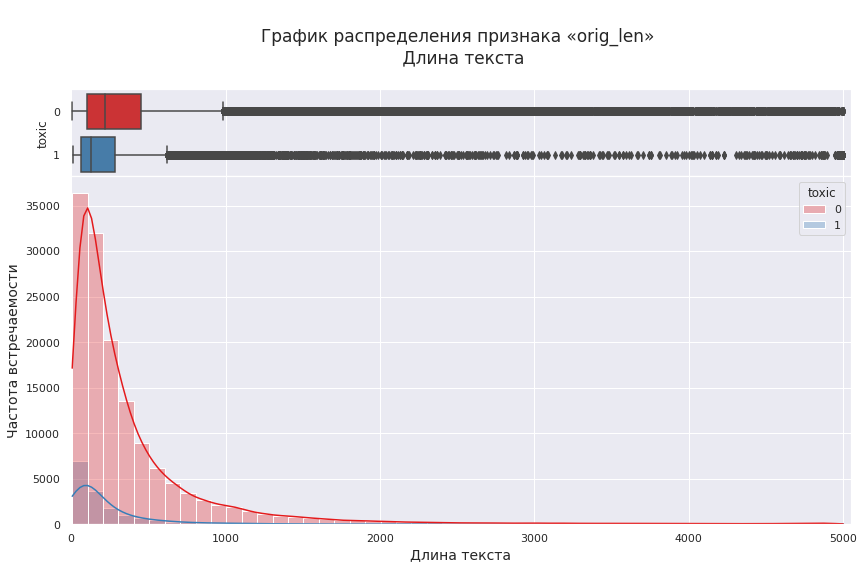

In [27]:
# оценка распределения признака длина текста
num_feature_research('orig_len', 'Длина текста', x_lims=(-10, 5050))

Распределение признака длины текста по форме напоминает распределение Пуассона и характеризуется длинным правым хвостом. Найдём значение границ, после которых данные в этом признаке можно будет отнести к аномальным значениями (выбросам). В качестве правой границы возможного отсечения возьмем Q3+3∙IQR.

Для определения границ выбросов и оценки доли выбросов по отношению ко всем имеющимся данным воспользуемся парой вспомогательных функций, которые были использованы в предыдущих проектах:
* `outliers_value()` - для определения границы, за которой будут находиться выбросы;
* `outliers_rate()` - для определения количества и доли выбросов по отношению ко всем данным.

In [28]:
# вспомогательная функция для определения границы выбросов
def outliers_value(df, column):
    """
    input:  df (pandas.DataFrame)  - исследуемый датафрейм
            column (str)           - название столбца (параметра, для которого будет определяться граница)
    output: val        (float)     - значение верхней границы, за которой будут находиться выбросы
    description: Функция находит и возвращает значения границ для исследуемого параметра за которыми будут 
                 находиться выбросы
    """
    # получение расчётных значений границ
    val_max = df[column].quantile(0.75) + (df[column].quantile(0.75) - df[column].quantile(0.25)) * 3.0
    val_min = df[column].quantile(0.25) - (df[column].quantile(0.75) - df[column].quantile(0.25)) * 3.0
    
    # проверка на превышение расчётных границ над фактическими значениями
    if val_max > df[column].max():
        val_max = df[column].max()
    if val_min < df[column].min():
        val_min = df[column].min()

    return val_min, val_max

Для хранения значений границ выбросов создадим пустой список и сохраним в него результаты работы функции `outliers_value()` для исследуемого параметра.

In [29]:
# пустой словарь для последующего хранения значений границ выбросов
outliers_values = []

# сохранение значений границ выбросов в словарь outliers_values с помощью функции outliers_value()
outliers_values = outliers_value(df, 'orig_len')

In [30]:
# оценка правой границы значений признака длина текста за которой будут находится выбросы
print_tab_row(
    'Значение правой границы для признака длина текста за которой находятся выбросы:', 
    outliers_values[1]
)

-----------------------------------------------------------------------------------------------
| Значение правой границы для признака длина текста за которой находятся выбросы: |   1461.00 |
-----------------------------------------------------------------------------------------------


Таки образом, комментарии длиной более `1461` символов можно отнести к выбросам. Посмотрим на долю текстов подобной длины по отношению ко всем данным.

In [31]:
# вспомогательная функция для определения количества и доли выбросов
def outliers_rate(df, column, direction='both', outliers_values=outliers_values):
    """
    input: df (pandas.DataFrame)   - исследуемый датафрейм
           column (str)            - название столбца (параметра, для которого будут находиться количество 
                                     и доля выбросов)
           direction (str)         - строка из трёх предопределённых значений (left, right, both), указывающая с 
                                     какой стороны распределения оценивать данные (слева, справа или с обоих)
           outliers_values (dict)  - словарь с границами выбросов
    output: print() значения количества и доли выбросов
    description: Функция расчитывает и выводит на печать значения количества и доли выбросов по отношению ко всем данным
    """
    
    outliers_count_max = df.loc[df[column] > outliers_values[1]].shape[0]
    outliers_count_min = df.loc[df[column] < outliers_values[0]].shape[0]
    outliers_count = 0
    
    if direction == 'left':
        outliers_count = outliers_count_min
    elif direction == 'right':
        outliers_count = outliers_count_max
    elif direction == 'both':
        outliers_count = outliers_count_max + outliers_count_min
        
    rate = round(outliers_count / df.shape[0] * 100, 2)
    
    return outliers_count, round(rate, 2)

In [32]:
# оценка доли текстов с длиной более 1461 символов
print_tab_row(
    'Доля текстов с длиной более 1461 символов относительно всех данных, %:', 
    outliers_rate(df, 'orig_len', outliers_values=outliers_values)[1]
)

-----------------------------------------------------------------------------------------------
| Доля текстов с длиной более 1461 символов относительно всех данных, %:          |      4.39 |
-----------------------------------------------------------------------------------------------


Также оценим долю токсичных комментариев в указанных текстах.

In [33]:
# оценка доли токсичных комментариев в текстах длиной более 1461 символов
print_tab_row(
    'Доля токсичных комментариев в текстах длиной более 1461 символов, %:', 
    df[df['orig_len'] > outliers_values[1]]['toxic'].mean() * 100
)

-----------------------------------------------------------------------------------------------
| Доля токсичных комментариев в текстах длиной более 1461 символов, %:            |      7.26 |
-----------------------------------------------------------------------------------------------


Доля токсичных комментариев среди отобранных "длинных" текстов немного меньше их доли в общем объеме данных. В целом объем "длинных" текстов составляет `≈4.4%` исходной выборки.

У нас недостаточно сведений о деятельности Интернет-магазина «Викишоп», но с большой долей уверенности можно предположить, что разумное ограничение на длину комментария/описания товара, оставляемого пользователем, вполне допустимо (в целом, это нормальная практика, когда при вводе текста пользователь ограничен в количестве вводимых символов/слов). Исключим указанные "длинные" тексты из дальнейшего рассмотрения.


In [34]:
# удаление текстов длиной более 1461 символов
df = df.loc[df['orig_len'] <= outliers_values[1]]

Признак: «orig_len»


count    151724.000000
mean        295.057282
std         286.486731
min           6.000000
25%          93.000000
50%         194.000000
75%         390.000000
max        1461.000000
Name: orig_len, dtype: float64

-----------------------------------------------------------------------------------------------
| Количество пропущенных значений признака «orig_len»:                            |   0.00000 |
-----------------------------------------------------------------------------------------------
| Доля пропущенных значений признака «orig_len»:                                  |   0.00000 |
-----------------------------------------------------------------------------------------------



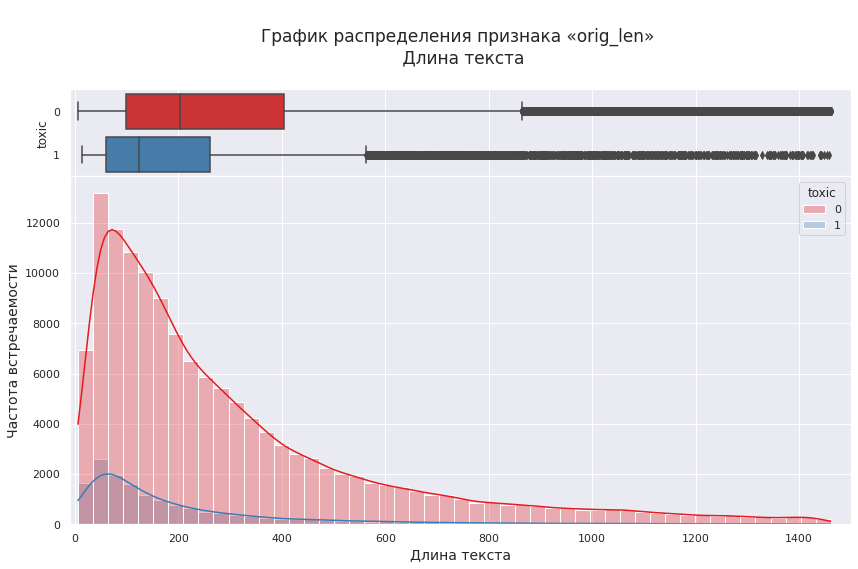

In [35]:
# оценка распределения признака длина текста
num_feature_research('orig_len', 'Длина текста', x_lims=(-10, 1500))

Теперь длинный правый хвост усечён и форма распределения текстов по длине лучше соотвествует распределению Пуассона.

#### Длина очищенного текста `clean_len`

Рассмотрим распределение данных по длине очищенного текста.

Признак: «clean_len»


count    151724.000000
mean        182.635984
std         181.633010
min           4.000000
25%          56.000000
50%         119.000000
75%         241.000000
max        1356.000000
Name: clean_len, dtype: float64

-----------------------------------------------------------------------------------------------
| Количество пропущенных значений признака «clean_len»:                           |   0.00000 |
-----------------------------------------------------------------------------------------------
| Доля пропущенных значений признака «clean_len»:                                 |   0.00000 |
-----------------------------------------------------------------------------------------------



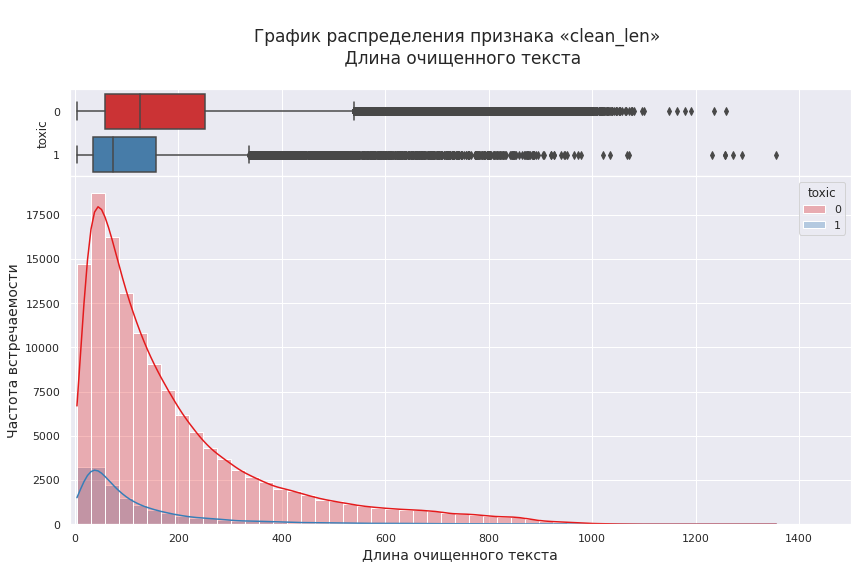

In [36]:
# оценка распределения признака длина очищенного текста
num_feature_research('clean_len', 'Длина очищенного текста', x_lims=(-10, 1500))

Также посмотрим на выбросы по длине текста после очистки, взяв в качестве возможной границы отсечения Q3+3∙IQR.

In [37]:
# пустой словарь для последующего хранения значений границ выбросов
outliers_values = []

# сохранение значений границ выбросов в словарь outliers_values с помощью функции outliers_value()
outliers_values = outliers_value(df, 'clean_len')

In [38]:
# оценка правой границы значений признака длина очищенного текста за которой будут находится выбросы
print_tab_row(
    'Значение правой границы для признака длина текста за которой находятся выбросы:', 
    outliers_values[1]
)

-----------------------------------------------------------------------------------------------
| Значение правой границы для признака длина текста за которой находятся выбросы: |    796.00 |
-----------------------------------------------------------------------------------------------


In [39]:
# оценка доли текстов с длиной очищенного текста более 796 символов
print_tab_row(
    'Доля текстов с длиной более 796 символов относительно всех данных, %:', 
    outliers_rate(df, 'clean_len', outliers_values=outliers_values)[1]
)

-----------------------------------------------------------------------------------------------
| Доля текстов с длиной более 796 символов относительно всех данных, %:           |      1.31 |
-----------------------------------------------------------------------------------------------


Также оценим долю токсичных комментариев в указанных текстах.

In [40]:
# оценка доли токсичных комментариев в текстах длиной более 796 символов
print_tab_row(
    'Доля токсичных комментариев в текстах длиной более 796 символов, %:', 
    df[df['clean_len'] > outliers_values[1]]['toxic'].mean() * 100
)

-----------------------------------------------------------------------------------------------
| Доля токсичных комментариев в текстах длиной более 796 символов, %:             |      4.16 |
-----------------------------------------------------------------------------------------------


Доля токсичных комментариев среди отобранных "длинных" текстов немного меньше их доли в общем объёме данных. В целом объём "длинных" текстов составляет `≈1.3%` от исходной выборки.

Учитывая то, что мы ввели ограничение на общую длину оставляемого комментария, целесообразно также рассмотреть и длины текстов после очистки (или их соотношение с исходной длиной). Можно предположить, что "обычные" комментарии (оставляемые пользователями) с точки зрения длины очщенных текстов отличаются, например, от сгенерированных ботами. В рамках построения настоящей модели мы исключим указанные "длинные" очищенные тексты из дальнейшего рассмотрения.

In [41]:
# удаление очищенных текстов длиной более 796 символов
df = df.loc[df['clean_len'] <= outliers_values[1]]

Признак: «clean_len»


count    149731.000000
mean        173.448157
std         164.160328
min           4.000000
25%          55.000000
50%         117.000000
75%         233.000000
max         796.000000
Name: clean_len, dtype: float64

-----------------------------------------------------------------------------------------------
| Количество пропущенных значений признака «clean_len»:                           |   0.00000 |
-----------------------------------------------------------------------------------------------
| Доля пропущенных значений признака «clean_len»:                                 |   0.00000 |
-----------------------------------------------------------------------------------------------



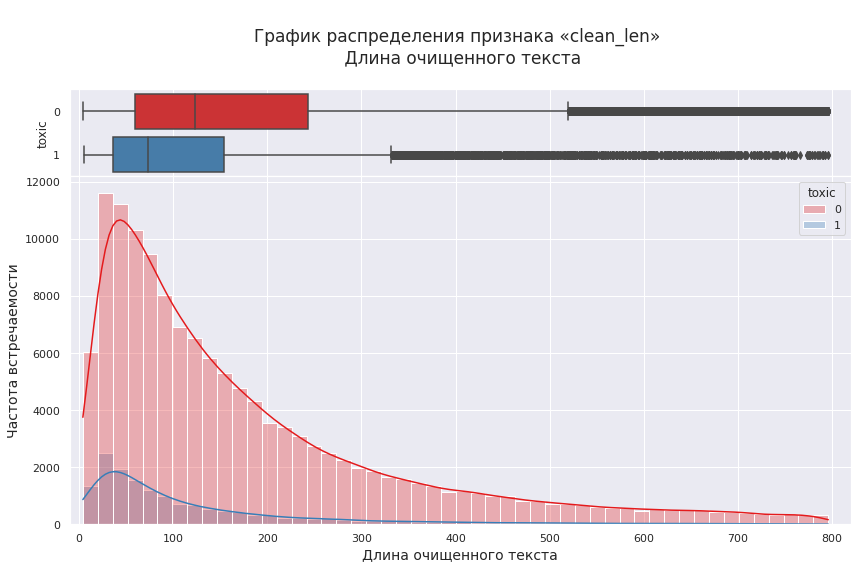

In [42]:
# оценка распределения признака длина текста
num_feature_research('clean_len', 'Длина очищенного текста', x_lims=(-10, 820))

Теперь форма распределения текстов по длине очищенного текста близка к распределению Пуассона. При этом распределения по целевому признаку различаются (смещены медиана и межквартильный размах), что говорит о потенциальной целесообразности применения указанного признака при обучении.

#### Доля сжатия `zip_ratio`

Рассмотрим распределение исходных текстов по соотношению объёма сжатого текста к исходному объёму.

Признак: «zip_ratio»


count    149731.000000
mean          0.441216
std           0.140117
min           0.015817
25%           0.338521
50%           0.405904
75%           0.511111
max           1.060606
Name: zip_ratio, dtype: float64

-----------------------------------------------------------------------------------------------
| Количество пропущенных значений признака «zip_ratio»:                           |   0.00000 |
-----------------------------------------------------------------------------------------------
| Доля пропущенных значений признака «zip_ratio»:                                 |   0.00000 |
-----------------------------------------------------------------------------------------------



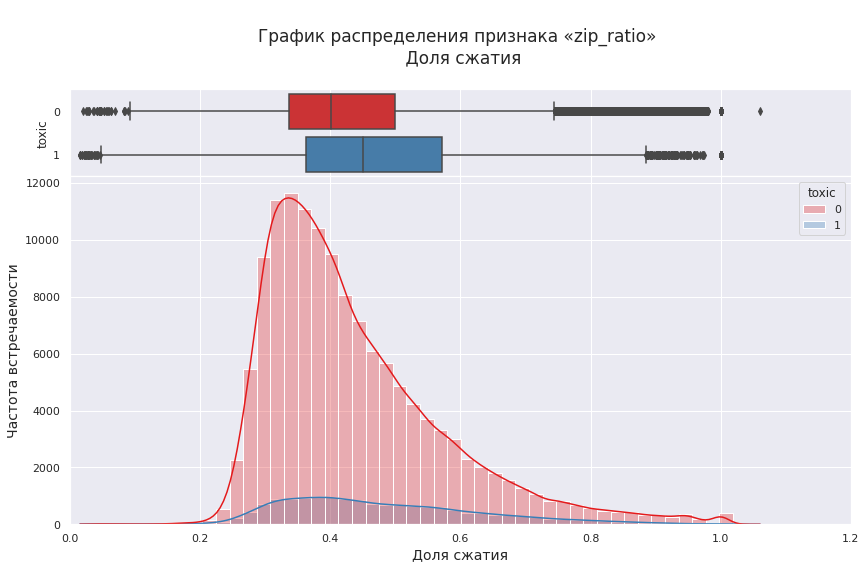

In [43]:
# оценка распределения признака длина текста
num_feature_research('zip_ratio', 'Доля сжатия', x_lims=(0, 1.2))

Судя по распределениям на графике, среди текстов с высоким коэффициентом сжатия доля токсичных комментариев выше. Попробуем оставить их для обучения (этот признак может оказаться значимым).

Изучим выбросы (аномальные значения) в области `1`. Для этого отобразим несколько примеров с ними.

In [44]:
df.loc[df['zip_ratio'] >= 1].tail(15)

,text,toxic,is_upper,clear_text,word_count,orig_len,clean_len,zip_len,zip_ratio
153446,Krajina Warfare Marbara,0,0,krajina warfare marbara,3,23,23,29,1.0
153511,REDIRECT User talk:Wesley Mouse,0,0,redirect user talk wesley mouse,5,31,31,33,1.0
153709,REDIRECT Talk:Cambodia Tiger FC,0,0,redirect talk cambodia tiger fc,5,31,31,35,1.0
154047,High Efficiency Rifle,0,0,high efficiency rifle,3,21,21,27,1.0
154059,REDIRECT Talk:Azide-alkyne Huisgen cycloaddition,0,0,redirect talk azide alkyne huisgen cycloaddition,6,48,48,49,1.0
155710,REDIRECT Talk:Florida College System,0,0,redirect talk florida college system,5,36,36,40,1.0
155893,REDIRECT Talk:Bicycle parking rack,0,0,redirect talk bicycle parking rack,5,34,34,38,1.0
156002,REDIRECT Talk:Sangeet Natak Akademi Award,0,0,redirect talk sangeet natak akademi award,6,41,41,42,1.0
156301,REDIRECT Talk:FC Neman Grodno,0,0,redirect talk fc neman grodno,5,29,29,33,1.0
156397,WikiProject Romania,0,0,wikiproject romania,2,19,19,26,1.0


Данные тексты в основном похожи на служебную сообщения, чем на комментарии, написанные человеком.

Удалим указанные тексты из дальнейшего рассмотрения предварительно оценив их долю.

In [45]:
# оценка доли комментариев со значением сжатия равным или большим 1
print_tab_row(
    'Доля комментариев со значением сжатия равным или большим 1, %:', 
    df.loc[df['zip_ratio'] >= 1].shape[0] / df.shape[0] * 100
)

-----------------------------------------------------------------------------------------------
| Доля комментариев со значением сжатия равным или большим 1, %:                  |      0.29 |
-----------------------------------------------------------------------------------------------


Данных со значением доли сжатия равным или большим 1 меньше одного процента. Произведём их удаление.

In [46]:
# удаление комментариев со значением сжатия равным или большим 1
df = df.loc[df['zip_ratio'] < 1]

#### Текст в UPPERCASE `is_upper`

Рассмотрим распределение значений признака токсичности комментариев `toxic` в атрибуте текст в UPPERCASE `is_upper`. Для этого создадим вспомогательную сводную таблицу.

In [47]:
# формирование сводной таблицы для распределения признака токсичности комментариев toxic в атрибуте is_upper - текст
# в UPPERCASE 
df_ups = df.pivot_table(index=['is_upper', 'toxic'], values='zip_len', aggfunc='count').reset_index()
df_ups

,is_upper,toxic,zip_len
0,0,0,133239
1,0,1,14505
2,1,0,531
3,1,1,1019



-----------------------------------------------------------------------------------------------
| Количество пропущенных значений признака «is_upper»:                            |         0 |
-----------------------------------------------------------------------------------------------
| Доля пропущенных значений признака «is_upper»:                                  |   0.00000 |
-----------------------------------------------------------------------------------------------



0    0.989618
1    0.010382
Name: is_upper, dtype: float64

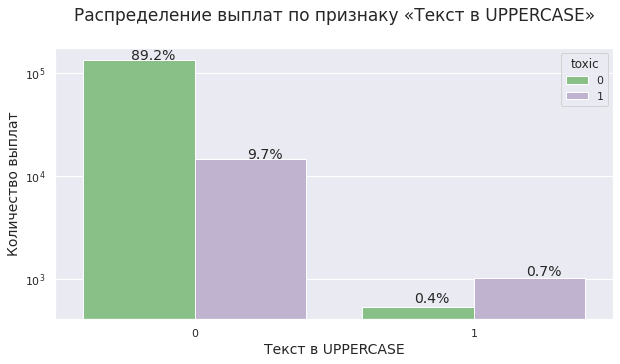

In [48]:
# оценка распределения признака токсичности комментариев toxic в атрибуте is_upper - текст в UPPERCASE
cat_feature_research(df_ups, 'is_upper', 'zip_len', 'toxic', 'Текст в UPPERCASE')

Доля токсичных комментариев в UPPERCASE намного выше, чем в среднем по набору данных. Указанный признак целесообразно использовать при обучении.

#### Формирование обучающей и тестовой выборок

Оценим общее количество записей в таблице, которое осталось после обработки данных, просмотрев сводную информацию.

In [49]:
# просмотр сводной информации о данных
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149294 entries, 0 to 159570
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   text        149294 non-null  object 
 1   toxic       149294 non-null  int64  
 2   is_upper    149294 non-null  int64  
 3   clear_text  149294 non-null  object 
 4   word_count  149294 non-null  int64  
 5   orig_len    149294 non-null  int64  
 6   clean_len   149294 non-null  int64  
 7   zip_len     149294 non-null  int64  
 8   zip_ratio   149294 non-null  float64
dtypes: float64(1), int64(6), object(2)
memory usage: 11.4+ MB


После предобработки в наборе данных осталось `149294` записи.

Выделим в исходном наборе данных обучающую и тестовую выборки со стратификацией по целевому признаку.

In [50]:
# разделение данных на обучающую и тестовую выборки со стратификацией по целевому признаку
df_train, df_test = train_test_split(df, test_size=0.15, random_state=RND, stratify=df['toxic'])

In [51]:
# масштабирование признаков
for_scale = ['clean_len', 'orig_len']

scaler = MinMaxScaler()
scaler.fit(df_train[for_scale])
df_train[for_scale] = scaler.transform(df_train[for_scale])
df_test[for_scale] = scaler.transform(df_test[for_scale])

/tmp/ipykernel_48/2628471313.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[for_scale] = scaler.transform(df_train[for_scale])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_48/2628471313.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

### Выводу по анализу и предобработке данных

> * Исходные данные представлены в виде таблицы, содержащей порядка `160` тысяч записей в виде двух признаков:
>     * текст (комментарий)
>     * признак токсичности комментария (целевой признак)
> * Дубликатов в исходном наборе данных нет. Доля токсичных комментариев в общем объёме данных - `10%`.
> * По условиям задачи моделирования требуется обучить модель, позволяющую классифицировать текст по признаку токсичности. Указанная модель предполагается к использованию Интернет-магазином «Викишоп» при оценке описаний товаров, оставляемых пользователями. Модель должна искать токсичные комментарии и отправлять их на модерацию.
> * Метрикой качества является *F1* с её целевым значением равным `0.75`. Метрика *F1* - это гармоническое среднее между точностью (*precision*) и полнотой (*recall*). Вычисляется по формуле:
$$
F = 2 ∙ \frac{Recall × Precision}{Recall + Precision}
$$
> * С точки зрения бизнеса интерпретировать метрики *precision* и *recall* можно следующим образом:
>     - точность (*precision*) тем выше, чем меньше ложноположительных прогнозов (*FP*) - т.е. ошибочно отправленных на модерацию нетоксичных комментариев;
>     - полнота (*recall*) тем выше, чем меньше ложноотрицательных прогнозов (*FN*) даёт модель, т.е. чем меньше количество пропущенных токсичных комментариев.
> * При обучении модели следует учитывать то, что целевые классы несбалансированы.
> * На этапе предобработки данных проведена очистка текста, обучающие признаки дополнены несколькими синтетическими признаками, в частности `zip_ratio` - соотношением объёма сжатого очищенного текста к исходному объёму текста.
> * На этапе анализа проведена оценка распределения значений обучающих признаков по целевым классам. Устранены отдельные выбросы, в том числе по длине представленных текстов на основе предположения об имеющихся на сайте Интернет-магазина «Викишоп» разумных ограничениях на длину комментария/описания товара, оставляемого пользователем.
> * Сформированы обучающая и тестовая выборки для последующего обучения моделей. При обучении моделей следует учитывать то, что присутствует дисбаланс в целевом признаке.

## Обучение моделей и выбор среди них лучшей

### Подготовка данных

Рассчитаем частоты слов обучающей выборки и на их основе составим матрицы TF-IDF для корпуса слов обучающей и тестовой выборок.

In [52]:
# получение TF-IDF матрицы для корпуса слов обучающей выборки
corpus = df_train['clear_text'].values.astype('U')

count_tf_idf = TfidfVectorizer()
tf_idf_train = count_tf_idf.fit_transform(corpus)

tf_idf_train

<126899x122561 sparse matrix of type '<class 'numpy.float64'>'
	with 2677566 stored elements in Compressed Sparse Row format>

In [53]:
# получение TF-IDF матрицы для корпуса слов тестовой выборки
corpus = df_test['clear_text'].values.astype('U')

tf_idf_test = count_tf_idf.transform(corpus) 

tf_idf_test

<22395x122561 sparse matrix of type '<class 'numpy.float64'>'
	with 458464 stored elements in Compressed Sparse Row format>

In [54]:
# выделение целевых признаков из обучающего и тестового наборов данных
target = 'toxic'

df_train_y= df_train[target]
df_test_y= df_test[target]

Дополним сформированные TF-IDF матрицы значениями дополнительных обучающих признаков.

In [55]:
# дополнение обучающей TF-IDF матрицы дополнительными признаками
df_train_X = tf_idf_train
df_train_X = hstack((df_train_X, np.array(df_train['is_upper'])[:,None]))
df_train_X = hstack((df_train_X, np.array(df_train['zip_ratio'])[:,None]))
df_train_X = hstack((df_train_X, np.array(df_train['clean_len'])[:,None]))
df_train_X = hstack((df_train_X, np.array(df_train['orig_len'])[:,None]))

In [56]:
# дополнение тестовой TF-IDF матрицы дополнительными признаками
df_test_X = tf_idf_test
df_test_X = hstack((df_test_X, np.array(df_test['is_upper'])[:,None]))
df_test_X = hstack((df_test_X, np.array(df_test['zip_ratio'])[:,None]))
df_test_X = hstack((df_test_X, np.array(df_test['clean_len'])[:,None]))
df_test_X = hstack((df_test_X, np.array(df_test['orig_len'])[:,None]))

In [57]:
# установим технику разбиения на фолды при кросс-валидации: число фолдов - 6 с перемешиванием
cv = StratifiedKFold(6, random_state=RND, shuffle=True)

# мера, используемая при кросс-валидации - F1, положительный класс - значение '1' (токсичные комментарии)
scoring = make_scorer(f1_score)

Проведём обучение и последующий анализ нескольких моделей на подготовленных данных.

In [58]:
# функция для печати лучшего значения метрики F1 на обучении и сводной информации о параметрах модели
def print_scores(grid_search, params, model_name, ret=False):
    """
    input:        grid_search (sklearn.model) - лучшая модель по результатам работы GridSearchCV
                  params (dict)               - лучшие параметры
                  model_name (str)            - название используемой модели
    output: grid_search.best_estimator_       - лучшая модель
    description:  Функция выводит на печать значение метрики F1 и параметры лучшей модели по результатам подобора 
                  гиперпараметров с помощью метода GridSearchCV на обучающих данных
    """
    print_tab_row(
        'Лучшее значение F1 для модели ' + model_name + ':',
        np.abs(grid_search.best_score_),
        total_width=75,
        col_1_format='| {: <60}|',
        col_2_format='{: >10.5f} |'
    )
        
    print ('| {: <60}|'.format('Лучшие параметры:'), end='')
    print(' ' * 11 + '|')
        
    best_parameters = grid_search.best_estimator_.get_params()
        
    for param_name in sorted(params.keys()):
        print('|\t{: <54}|'.format(param_name), end='')
        print('{: >10} |'.format(str(best_parameters[param_name])))
    print('-' * 75)
            
    if ret == True:
        return grid_search.best_estimator_
    else:
        return None

In [59]:
# функция для печати значения метрики F1 на тестовых данных
def print_scores_on_test(grid_search, params, x_test, y_test, model_name):
    """
    input:        grid_search (sklearn.model) - лучшая модель по результатам работы GridSearchCV
                  params (dict)               - лучшие параметры
                  x_test (pandas.DataFrame)   - тестовый набор данных
                  y_test (pandas.DataFrame)   - таргеты из тестового набора данных
                  model_name (str)            - название используемой модели
    output:       test_score (float)          - значение метрики F1 на тестовых данных
    description:  Функция выводит на печать значение метрики F1 и параметры лучшей модели по результатам подбора 
                  гиперпараметров с помощью метода GridSearchCV на обучающих данных
    """
    print('-' * 75)
    print ('| {: <60}|'.format('Параметры модели:'), end='')
    print(' ' * 11 + '|')
    
    best_parameters = grid_search.best_estimator_.get_params()
    
    for param_name in sorted(params.keys()):
        print('|\t{: <54}|'.format(param_name), end='')
        print('{: >10} |'.format(str(best_parameters[param_name])))
        
    predicts = grid_search.predict(x_test)
    test_score = f1_score(y_test, predicts)
    
    print_tab_row(
        'F1 на тестовых данных для ' + model_name + ':',
        test_score,
        total_width=75,
        col_1_format='| {: <60}|',
        col_2_format='{: >10.5f} |'
    )
    
    return test_score

### DummyClassifier

В качестве базовой модели получим значение *F1* метрики для *DummyClassifier*. Параметром стратегии выберем `stratified`, которая вернёт вероятности отнесения к одному из классов в зависимости от распределения классов в обучающей выборке.

Итеративно выполним `5000` пседослучайных подобных «предсказаний» и выберем из них то, которое обеспечит максимальное значение *F1* метрики.

In [60]:
%%time
# получение результатов работы лучшей модели на основе классификатора DummyClassifier на тестовой выборке
f1_dm_values = []
best_dm_result = 0

start_time = datetime.datetime.now()

for i in range(5000):
    dm_model = DummyClassifier(strategy='stratified', random_state=i)
    dm_model.fit(df_train, df_train_y)
    probs = dm_model.predict_proba(df_test)
    
    predicts = (probs[:,1] > 0.5) * 1
    dm_result = f1_score(df_test_y, predicts)
    f1_dm_values.append(dm_result)
    
    if dm_result > best_dm_result:
        best_dm_result = dm_result
        
learning_time_dm = (datetime.datetime.now()-start_time).seconds

CPU times: user 50.3 s, sys: 283 ms, total: 50.5 s
Wall time: 50.6 s


In [61]:
# значение метрики F1 для DummyClassifier на тестовых данных
print_tab_row(
    'F1 на тестовых данных для DummyClassifier:', 
    best_dm_result,
    total_width=75,
    col_1_format='| {: <60}|',
    col_2_format='{: >10.5f} |'
)

---------------------------------------------------------------------------
| F1 на тестовых данных для DummyClassifier:                  |   0.12437 |
---------------------------------------------------------------------------


Для оценки распределения полученных значений создадим вспомогательную функцию.

In [62]:
# функция для оценки распределения частот
def func_freq_est(data, feature, chart_title, x_lims=(0, 1)):    
    """
    input: data (pandas.Series) - данные для построения гистограммы и диаграммы размаха
           feature (str)        - наименование признака
           chart_title (str)    - наименование графика
           x_lims (tuple)       - диапазон значений по оси X
    output: None
    description: Функция принимает input параметры, выводит таблицу с описательными статистиками, строит диаграмму 
                 размаха и графики распределение частот для исследуемого признака
    """
    
    sns.set()
    sns.set_palette(palette='CMRmap')
    f, axes = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw=dict(height_ratios=[1, 4]))
    f.subplots_adjust(hspace=0)

    axes[0].set_title(f'График распределения метрики «{feature}» \n {chart_title}', fontsize=17)
    axes[0] = sns.boxplot(data=data, orient='h', ax=axes[0], palette='BuPu')
    axes[0].set_xlim(x_lims)
    axes[0].set_xticklabels([])

    axes[1] = sns.histplot(
        data=data,
        alpha=0.45,
        ax=axes[1],
        kde=True,
        stat='frequency',
        bins=50
    )
    axes[1].set_ylabel('Частота встречаемости', fontsize=14)
    axes[1].set_xlabel('Значение F1', fontsize=14)
    axes[1].set_xlim(x_lims)
    plt.show();
    
    return None

Вызовем функцию *func_freq_est()* для оценки распределения частот полученных значений метрики *F1* для модели *DummyClassifier*.

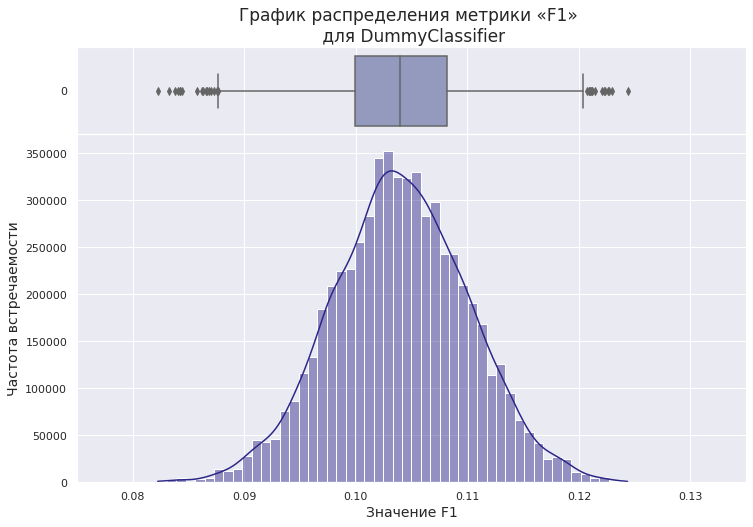

In [63]:
# оценка распределеня полученных значений
func_freq_est(
    pd.DataFrame(f1_dm_values).rename(columns={0: 'F1'})['F1'],
    'F1',
    'для DummyClassifier',
    x_lims=(0.075, 0.135)
)

> * Для модели на основе классификатора *DummyClassifier* на тестовой выборке в результате проведения `5000` итераций получено лучшее значение метрики *F1*, равное `0.124`.
> * Форма распределения полученных значений *F1* метрики практически идеально симметрична и точно соотвествует форме Гауссовского распределения, что подтверждает случайность полученных значений.

### RandomPredict

Получим значение *F1* метрики от случайных значений целевой переменной. Для этого выполним `5000` пседослучайных рандомных «предсказаний» и выберем из них то, которое обеспечит максимальное значение *F1* метрики.

In [64]:
%%time
# получение значений точности для случайно сгенерированных значений целевого признака
f1_rnd_values = []
best_rnd_result = 0

start_time = datetime.datetime.now()

for i in range(5000):
    predictions = np.random.randint(2, size=df_test.shape[0])
    rnd_result = f1_score(df_test[target], predictions)
    f1_rnd_values.append(rnd_result)
    
    if rnd_result > best_rnd_result:
        best_rnd_result = rnd_result
        
learning_time_rnd = (datetime.datetime.now()-start_time).seconds

CPU times: user 32.9 s, sys: 116 ms, total: 33 s
Wall time: 33 s


In [65]:
# значение метрики F1 для RandomPredict на тестовых данных
print_tab_row(
    'F1 на тестовых данных для RandomPredict:', 
    best_rnd_result,
    total_width=75,
    col_1_format='| {: <60}|',
    col_2_format='{: >10.5f} |'
)

---------------------------------------------------------------------------
| F1 на тестовых данных для RandomPredict:                    |   0.18523 |
---------------------------------------------------------------------------


Оценим распределения частот полученных значений метрики *F1* для рандомных предсказаний *RandomPredict*.

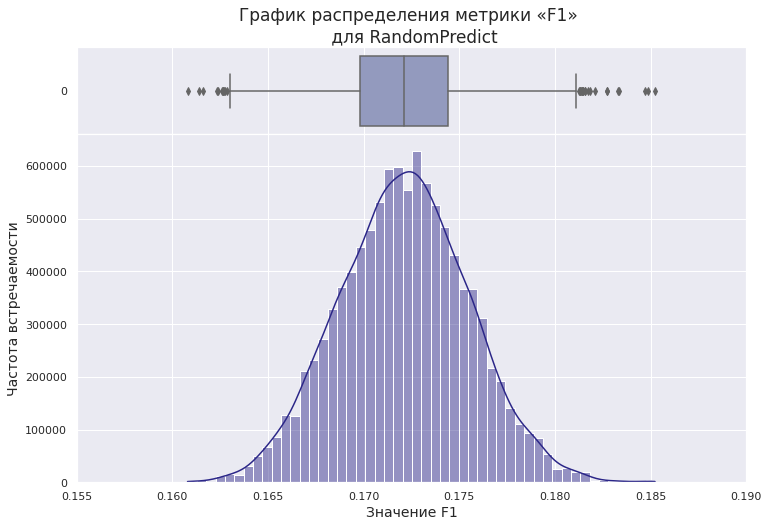

In [66]:
# оценка описательных статистик и распределений признаков даты объявлений
func_freq_est(pd.DataFrame(f1_rnd_values).rename(columns={0:'f1'})['f1'],
    'F1',
    'для RandomPredict',
    x_lims=(0.155, 0.19)
)

> * На основе случайных предсказаний *RandomPredict* на тестовой выборке, полученных в результате проведения `5000` итераций получено лучшее значение метрики *F1*, равное `0.184`.
> * Форма распределения полученных значений *F1* метрики практически идеально симметрична и точно соотвествует форме Гауссовского распределения, что подтверждает случайность полученных значений.

### LinearSVC

Проведём обучение классификатора на основе опорных векторов *LinearSVC*.

In [67]:
# создание моделей на основе LinearSVC классификатора с заданными для перебора диапазонами гиперпараметров
model_svc = LinearSVC(random_state=RND, max_iter=5000, class_weight='balanced')


# для экономии времени при проверке ноутбука отключил диапазоны значений и оставил уже подобранные
#params = {
#    'model__C': [0.5, 1.0, 1.5],
#    'model__dual': [True, False]
#}

params = {
    'model__C': [0.5],
    'model__dual': [True]
}

In [68]:
# определение поиска по заданным значениям гиперпараметров для LinearSVC классификатора
grid_search = GridSearchCV(
    Pipeline([('model', model_svc)]), 
    param_grid=params, 
    cv=cv, 
    scoring=scoring
)

In [69]:
%%time
# обучение моделей на основе LinearSVC классификатора
start_time = datetime.datetime.now()

grid_search.fit(df_train_X, df_train_y)
learning_time_svc = (datetime.datetime.now()-start_time).seconds

print_scores(grid_search, params, 'LinearSVC')

---------------------------------------------------------------------------
| Лучшее значение F1 для модели LinearSVC:                    |   0.77197 |
---------------------------------------------------------------------------
| Лучшие параметры:                                           |           |
|	model__C                                              |       0.5 |
|	model__dual                                           |      True |
---------------------------------------------------------------------------
CPU times: user 19.6 s, sys: 260 ms, total: 19.9 s
Wall time: 20.1 s


In [70]:
# получение результатов работы лучшей модели на основе LinearSVC классификатора на тестовой выборке
f1_score_svc = print_scores_on_test(
    grid_search, params, df_test_X, df_test_y, 'LinearSVC'
)

---------------------------------------------------------------------------
| Параметры модели:                                           |           |
|	model__C                                              |       0.5 |
|	model__dual                                           |      True |
---------------------------------------------------------------------------
| F1 на тестовых данных для LinearSVC:                        |   0.76768 |
---------------------------------------------------------------------------


> * Для модели на основе LinearSVC классификатора на тестовой выборке получено значение метрики *F1*, равное `0.768`. Полученное значение удовлетворяет выдвинутому в задании условию *F1* `≥0.75`.

### Логистическая регрессия

Обучим модель логистической регрессии *LogisticRegression* и сравним полученное на её основе значение метрики *F1* с аналогичным значением метрики для *LinearSVC* классификатора.

In [71]:
# создание моделей на основе логистической регрессии с заданными для перебора диапазонами гиперпараметров 
model_lr = LogisticRegression(max_iter=5000, solver='liblinear', class_weight='balanced', random_state=RND)

# для экономии времени при проверке ноутбука отключил диапазоны значений и оставил уже подобранные
#params = {
#    'model__C': np.linspace(5, 6, 10, endpoint=False),
#    'model__fit_intercept': [True, False]
#}

params = {
    'model__C': [5.8],
    'model__fit_intercept': [True]
}

In [72]:
# определение поиска по заданным значениям гиперпараметров для логистической регрессии
grid_search = GridSearchCV(
    Pipeline([('model', model_lr)]), 
    param_grid=params, 
    cv=cv, 
    scoring=scoring
)    

In [73]:
%%time
# обучение моделей на основе логистической регрессии
start_time = datetime.datetime.now()
grid_search.fit(df_train_X, df_train_y)
learning_time_lr = (datetime.datetime.now()-start_time).seconds

print_scores(grid_search, params, 'логистической регрессии')

---------------------------------------------------------------------------
| Лучшее значение F1 для модели логистической регрессии:      |   0.77408 |
---------------------------------------------------------------------------
| Лучшие параметры:                                           |           |
|	model__C                                              |       5.8 |
|	model__fit_intercept                                  |      True |
---------------------------------------------------------------------------
CPU times: user 1min 2s, sys: 1min 43s, total: 2min 46s
Wall time: 2min 46s


In [74]:
# получение результатов работы лучшей модели на основе логистической регрессии на тестовой выборке
f1_score_lr = print_scores_on_test(
    grid_search, params, df_test_X, df_test_y, 'логистической регрессии'
)

---------------------------------------------------------------------------
| Параметры модели:                                           |           |
|	model__C                                              |       5.8 |
|	model__fit_intercept                                  |      True |
---------------------------------------------------------------------------
| F1 на тестовых данных для логистической регрессии:          |   0.76954 |
---------------------------------------------------------------------------


Оценим зависимость метрик *precision*, *recall* и *f1* от используемых порогов отнесения к целевым классам *threshold*. Для этого создадим вспомогательные функции для формирования датафрейма со значениями метрик *get_proba_df()* и *show_scores()* непосредственно для построения графиков.

In [75]:
# функция формирования датафрейма со значениями метрик precision, recall и f1 в диапазоне порогов
def get_proba_df(model_fitted, x_test, y_test, is_meta=False):
    """
    input: model_fitted (classifier)     - обученная модель
           x_test (pandas.Series)        - значения recall для оси Y
           y_test (pandas.Series)        - значения precision для оси Y
           f1_vals (pandas.Series)       - значения F1 метрики для оси Y
    output: df_scores (pandas.DataFrame) - датафрейм с метриками precision, recall и f1 в диапазоне порогов threshold
    description: Функция принимает input параметры и возвращает датафрейм с метриками precision, recall и f1 в диапазоне
                 порогов threshold
    """
    if is_meta:
        probabilities_valid = model_fitted.predict_proba((x_test[0], x_test[1]))
    else:
        probabilities_valid = model_fitted.predict_proba(x_test)
    probabilities_one_valid = probabilities_valid[:, 1]

    scores = []
    for threshold in np.arange(0.1, 0.9, 0.01):
        predicted_valid = probabilities_one_valid > threshold
        precision = precision_score(y_test, predicted_valid)
        recall = recall_score(y_test, predicted_valid)
        f1 = f1_score(y_test, predicted_valid)

        scores.append([threshold, precision, recall, f1])
        
    df_scores = pd.DataFrame(scores, columns=['threshold', 'precision', 'recall', 'f1'])
    return df_scores

In [76]:
# функция построения графика зависимости precision, recall, F1 от порога threshold
def show_scores(x_vals, recall_vals, precision_vals, f1_vals, title):
    """
    input: x_vals (pandas.Series)      - значения порога threshold для оси X
           recall_vals (pandas.Series) - значения recall для оси Y
           precision (pandas.Series)   - значения precision для оси Y
           f1_vals (pandas.Series)     - значения F1 метрики для оси Y
           title (str)                 - строка для названия графика
    output: None
    description: Функция принимает input параметры и строит график зависимости precision, recall, F1 от 
                 порога threshold
    """
    fig, axes = plt.subplots(1,1, figsize=(12, 6))
    
    axes.plot(x_vals, recall_vals, label='recall', color='#016795', linewidth=3)
    axes.plot(x_vals, precision_vals, label='precision', color='#FF9408', linewidth=3)
    axes.axhline(y=0.75, label='0.75', color='#FE019A', linestyle='--')
    axes.fill_between(x_vals, f1_vals, alpha=0.35, label='threshold')
    
    plt.title(f'\nГрафик зависимости precision, recall, F1 от порога threshold\n для модели на основе {title}', 
              fontsize=17)
    plt.xlabel('threshold', fontsize=14)
    plt.ylabel('precision / recall', fontsize=14)
    plt.legend(loc='lower left', fontsize=14)
    plt.ylim([0.5, 1])
    plt.show();
    
    return None

Используем созданную функцию *get_proba_df()* для получения датафрейма со значениями метрик *precision*, *recall* и *f1* в зависимости от значения порогов *threshold*.

In [77]:
# получение датафрейма со значениями метрик
df_scores = get_proba_df(grid_search, df_test_X, df_test_y)

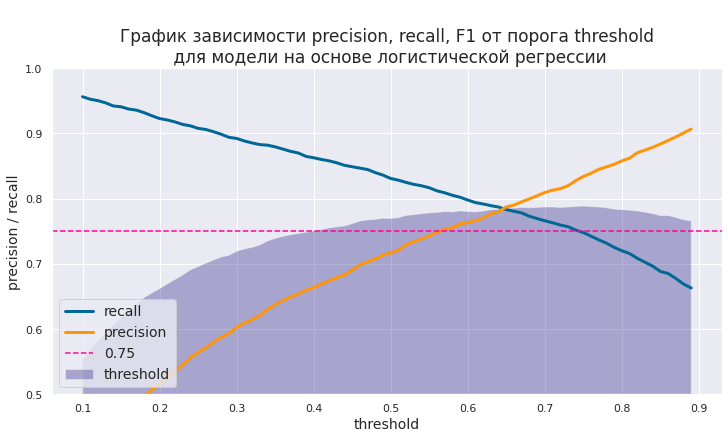

In [78]:
# построение графика зависимости precision, recall, F1 от порога threshold для логистической регрессии
show_scores(
    df_scores['threshold'], 
    df_scores['recall'], 
    df_scores['precision'], 
    df_scores['f1'], 
    'логистической регрессии'
)

> * Для модели на основе логистической регрессии на тестовой выборке получено значение метрики *F1*, равное `0.770`. Оно также удовлетворяет выдвинутому в задании условию *F1* `≥0.75` и незначительно превосходит аналогичное значение метрики для *LinearSVC* классификатора.
> * По графику зависимости метрик *precision*, *recall*, *F1* от порога *threshold* можно сделать вывод, что выдвинутое в задании условие *F1* `≥0.75` выполняется моделью в диапазоне значений порога *threshold* от `0.4` и выше. Точкой пересечения графиков *precision* и *recall* является значение порога `0.65`.

### CatBoostClassifier

Перейдём к рассмотрению модели, которая учитывает не только частоты слов в тексте, но и частоты различных синтаксических *N*-грамм (последовательностей слов). Она может быть реализована с помощью классификатора *CatBoostClassifier*.

В модель сразу подставлены оптимизированные гиперпараметры, полученные при расчётах на GPU на локальной машине, так как их подбор на CPU занимает слишком много времени.

Так как библиотека градиентного бустинга *CatBoost* может работать непосредственно с текстовыми данными, а не только с их частотным представлением TF-IDF, упакованным в *Sparse matrices*, то сформируем соотвествующие наборы обучающих и тестовых данных.

Дополнительно разделим обучающую выборку на обучающую и валидационную (доля валидационной примерно соответствует доле тестовой выборки для финальной проверки модели).

In [79]:
# выделение валидационной выборки
train, valid = train_test_split(
    df_train, test_size=0.15, stratify=df_train['toxic'], shuffle=True, random_state=RND
)

In [80]:
# разделение признаков на категориальные, текстовые и числовые
feature_names = [c for c in df_train.columns if c not in ['toxic', 'text']]

cat_features = ['is_upper']

text_features = ['clear_text']

In [81]:
# создание модели на основе CatBoostClassifier с заданным набором параметров
model_cb = CatBoostClassifier(
    depth=10,
    learning_rate=0.05,
    cat_features=cat_features,
    text_features=text_features,
    verbose=500,
    eval_metric='F1',
    task_type="GPU",
    iterations=1000,
    thread_count=-1,
    random_state=RND,
    
    text_processing = {
        "tokenizers" : [{
            "tokenizer_id" : "Space",
            "separator_type" : "ByDelimiter",
            "delimiter" : " "
        }],

        "dictionaries" : [{
            "dictionary_id" : "BiGram",
            "token_level_type": "Letter",
            "max_dictionary_size" : "150000",
            "occurrence_lower_bound" : "1",
            "gram_order" : "2"
        },{
            "dictionary_id" : "Trigram",
            "max_dictionary_size" : "150000",
            "token_level_type": "Letter",
            "occurrence_lower_bound" : "1",
            "gram_order" : "3"
        },{
            "dictionary_id" : "Fourgram",
            "max_dictionary_size" : "150000",
            "token_level_type": "Letter",
            "occurrence_lower_bound" : "1",
            "gram_order" : "4"
        },{
            "dictionary_id" : "Fivegram",
            "max_dictionary_size" : "150000",
            "token_level_type": "Letter",
            "occurrence_lower_bound" : "1",
            "gram_order" : "5"
        },{
            "dictionary_id" : "Sixgram",
            "max_dictionary_size" : "150000",
            "token_level_type": "Letter",
            "occurrence_lower_bound" : "1",
            "gram_order" : "6"
        }
        ],

        "feature_processing" : {
            "default" : [
                    {
                    "dictionaries_names" : ["BiGram", "Trigram", "Fourgram", "Fivegram", "Sixgram"],
                    "feature_calcers" : ["BoW"],
                    "tokenizers_names" : ["Space"]
                },
                    {
                "dictionaries_names" : ["BiGram", "Trigram", "Fourgram", "Fivegram", "Sixgram"],
                "feature_calcers" : ["NaiveBayes"],
                "tokenizers_names" : ["Space"]
            },{
                "dictionaries_names" : [ "BiGram", "Trigram", "Fourgram", "Fivegram", "Sixgram"],
                "feature_calcers" : ["BM25"],
                "tokenizers_names" : ["Space"]
            },
            ],
        }
    }
)

In [82]:
# создание валидационного набора данных
eval_df = Pool(valid[feature_names], valid[target], cat_features=cat_features, text_features=text_features)

In [83]:
%%time
# сохранение результатов подбора гиперпараметров с использованием pickle для сокращения времени работы ячейки при
# повторном перезапуске
try:
    with open('cb_model.pkl', 'rb') as f:
        model_cb = pickle.load(f)
except FileNotFoundError:
    start_time = datetime.datetime.now()
    # обучение модели на основе градиентного бустинга CatBoostClassifier
    model_cb.fit(
        train[feature_names], train[target], eval_set=eval_df, early_stopping_rounds=150, plot=False
        )
    
    learning_time_cb = (datetime.datetime.now()-start_time).seconds
    
    with open('cb_model.pkl', 'wb') as f:
        pickle.dump(model_cb, f)

CPU times: user 75 ms, sys: 77.8 ms, total: 153 ms
Wall time: 845 ms


In [84]:
# получение метрики F1 модели на основе CatBoostClassifier на тестовой выборке
f1_score_cb = f1_score(df_test[target], model_cb.predict(df_test[feature_names]))

print_tab_row(
    'F1 на тестовых данных для CatBoostClassifier:', 
    f1_score_cb,
    total_width=75,
    col_1_format='| {: <60}|',
    col_2_format='{: >10.5f} |'
)

---------------------------------------------------------------------------
| F1 на тестовых данных для CatBoostClassifier:               |   0.78529 |
---------------------------------------------------------------------------


Оценим значения метрик *precision*, *recall* и *f1* в зависимости от значений порога *threshold* для модели на основе *CatBoostClassifier*.

In [85]:
# получение датафрейма со значениями метрик
df_scores = get_proba_df(model_cb, df_test[feature_names], df_test[target])

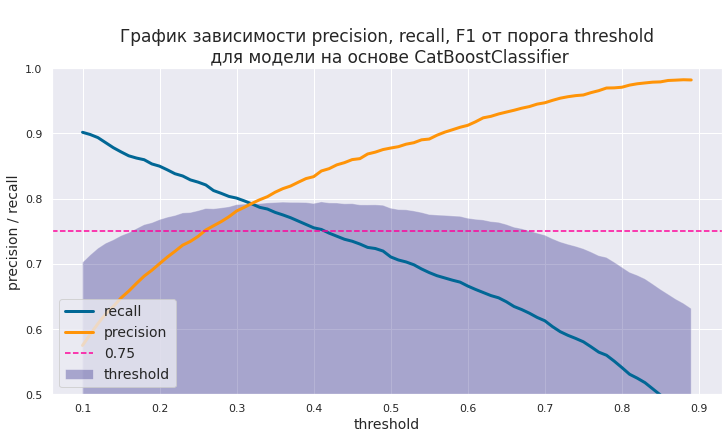

In [86]:
# построение графика зависимости precision, recall, F1 от порога threshold для CatBoostClassifier
show_scores(
    df_scores['threshold'], 
    df_scores['recall'], 
    df_scores['precision'], 
    df_scores['f1'], 
    'CatBoostClassifier'
)

> * Для модели на основе *CatBoostClassifier* на тестовой выборке получено значение метрики *F1*, равное `0.785`, что примерно на `1.5%` лучше аналогичной метрики для модели на основе логистической регрессии.
> * По графику зависиммости метрик *precision*, *recall*, *F1* от порога *threshold* можно сделать вывод, что выдвинутое в задании условие *F1* `≥0.75` выполняется моделью в диапазоне значений порога *threshold* от `0.16` до `0.68`. Точкой пересечения графиков *precision* и *recall* является значение порога `0.32`.

### StackingClassifier

Попробуем улучшить качество предсказаний созданием мета-классификатора на основе стекинга моделей линейной регрессии и *CatBoostClassifier*.

In [87]:
# класс для стекинга моделей и создания на их основе мета-классификатора
class StackingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, meta_classifier, models, cv=3):
        self.meta_classifier=meta_classifier
        self.models = models
        self.kf = KFold(n_splits=cv)
    
    def fit(self, X, y):
        models_to_train = [clone(model) for model in self.models]
        X_new = np.zeros((y.shape[0], len(models_to_train)))

        for train_indexes, test_indexes in self.kf.split(y):
            model_on_linreg = models_to_train[0]
            model_on_cboost = models_to_train[1]
            model_on_linreg.fit(X[0].tocsr()[train_indexes], y.iloc[train_indexes])
            model_on_cboost.fit(X[1].iloc[train_indexes, :], y.iloc[train_indexes])

            X_new[test_indexes, 0] = model_on_linreg.predict_proba(X[0].tocsr()[test_indexes])[:, 0]
            X_new[test_indexes, 1] = model_on_cboost.predict_proba(X[1].iloc[test_indexes, :])[:, 0]
        self.meta_classifier.fit(X_new, y)
        
    def predict_proba(self, X):
        model_on_linreg = self.models[0]
        model_on_cboost = self.models[1]
        X_new = np.zeros((X[0].shape[0], len(self.models)))
        X_new[:, 0] = model_on_linreg.predict_proba(X[0])[:, 0] 
        X_new[:, 1] = model_on_cboost.predict_proba(X[1])[:, 0]
        return self.meta_classifier.predict_proba(X_new)

In [88]:
# создание модели для мета-классификатора
meta_classifier = LogisticRegression(max_iter=250, C=6, solver='liblinear', random_state=RND)

In [89]:
# создание экземпляра класса мета-классификатора
classifier = StackingClassifier(meta_classifier, [grid_search.best_estimator_, model_cb])

Чтобы сэкономить время с помощью библиотеки *pickle* загрузим уже обученную ранее модель мета-классификатора. Если требуемый файл не будет найден, то проведём обучение заново.

In [90]:
# сохраниние результатов подбора гиперпараметров с использованием pickle для сокращения времени работы ячейки при
# повторном перезапуске
try:
    with open('meta_classifier.pkl', 'rb') as f:
        classifier = pickle.load(f)
except FileNotFoundError:
    start_time = datetime.datetime.now()
    # обучение meta_classifier
    classifier.fit((df_train_X, df_train[feature_names]), df_train_y)
    
    learning_time_st = (datetime.datetime.now()-start_time).seconds
    
    with open('meta_classifier.pkl', 'wb') as f:
        pickle.dump(classifier, f)

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.1.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator Pipeline from version 1.1.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


Результатом работы мета-классификатора являются вероятности принадлежности объекта к классам `0` или `1`. Чтобы получить сами предсказания определим пороговое значение для разделения равным `0.5`. 

In [91]:
# получение предсказаний на основе вероятностей отнесения объекта к одному из классов
probs = classifier.predict_proba((df_test_X, df_test[feature_names]))
predicts = (probs[:,1] > 0.5) * 1

In [92]:
# получение метрики F1 модели на основе StackingClassifier на тестовой выборке
f1_score_st = f1_score(df_test[target], predicts)

print_tab_row(
    'F1 на тестовых данных для StackingClassifier:', 
    f1_score_st,
    total_width=75,
    col_1_format='| {: <60}|',
    col_2_format='{: >10.5f} |'
)

---------------------------------------------------------------------------
| F1 на тестовых данных для StackingClassifier:               |   0.80763 |
---------------------------------------------------------------------------


Оценим значения метрик *precision*, *recall* и *f1* в зависимости от значений порога *threshold* для модели на основе *StackingClassifier*.

In [93]:
# получение датафрейма со значениями метрик
df_scores = get_proba_df(classifier, (df_test_X, df_test[feature_names]), df_test[target], is_meta=True)

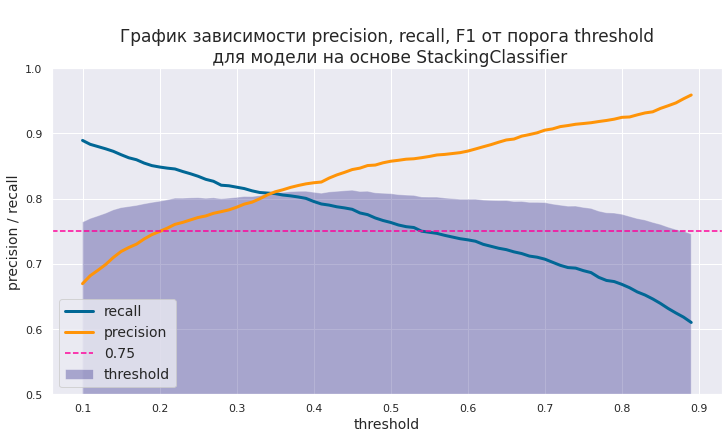

In [94]:
# построение графика зависиммости precision, recall, F1 от порога threshold для CatBoostClassifier
show_scores(
    df_scores['threshold'], 
    df_scores['recall'], 
    df_scores['precision'], 
    df_scores['f1'], 
    'StackingClassifier'
)

> * В результате стекинга моделей логистической регрессии и градиентного бустинга *CatBoostClassifier* создан мета-классификатор *StackingClassifier*, который позволил на тестовой выборке достичь значения метрики *F1*, равного `0.808`, что более чем на `2.0%` лучше результата наиболее сильной модели (*CatBoostClassifier*), входящей в его состав.
> * По графику зависимости метрик *precision*, *recall*, *F1* от порога *threshold* можно сделать вывод, что стекинг моделей *CatBoostRegressor* и логистической регрессии не только непосредственно увеличил значение метрики *F1*, но также расширил диапазон значений порога *threshold* таким образом, что выдвинутое в задании условие *F1* `≥0.75` выполняется моделью практически во всём диапазоне значений порога. Точкой пересечения графиков *precision* и *recall* является значение порога `0.34`.

### Сравнительный анализ моделей

Создадим сводную таблицу для сравнительного анализа обученных выше моделей.

In [95]:
# создание сводной таблицы по результатам обучения различных моделей
result_df = pd.DataFrame(
    [
        [round(best_dm_result, 3), learning_time_dm],
        [round(best_rnd_result, 3), learning_time_rnd],
        [round(f1_score_svc, 3), learning_time_lr],
        [round(f1_score_lr, 3), learning_time_svc],
        [round(f1_score_cb, 3), '59 (GPU)'],
        [round(f1_score_st, 3), '198 (GPU)']
    ],
    columns=['f1_score', 'learning_time'],
    index=[
        'DummyClassifier',
        'RandomPredict',
        'LinearSVC', 
        'LogisticRegression', 
        'CatBoostClassifier', 
        'StackingClassifier'
    ]
)

# просмотр полученных результатов
result_df

,f1_score,learning_time
DummyClassifier,0.124,50
RandomPredict,0.185,33
LinearSVC,0.768,166
LogisticRegression,0.770,20
CatBoostClassifier,0.785,59 (GPU)
StackingClassifier,0.808,198 (GPU)


Для наглядного графического сравнения различных алгоритмов создадим вспомогательную функцию *algo_comparison()*.

In [96]:
# функция визуального сравнение моделей
def algo_comparison(x_vals, y_vals, title, x_label, v_line):
    """
    input: x_vals (pandas.Series)  - значения метрики F1 по различным сравниваемым моделям
           y_vals (pandas.indexes) - индексы значений (наименования моделей)
           title (str)             - наименование графика
           x_label (str)           - подпись к оси х
           v_line (numpy.float64)  - значение нижней границы метрики по требованию задания
    output: None
    description: Функция принимает input параметры и строит столбчатую диаграмму по значениям метрик F1 
                 различных моделей для их визуального сравнения с границей, определённой по требованию задания
    """
    print()
    sns.set()
    sns.set_palette(palette='muted')
    fig = plt.figure(figsize=(10, 5))
    fig.suptitle(title, fontsize=17)
    ax = sns.barplot(x=x_vals, y=y_vals)
    ax.set_yticklabels(y_vals, fontsize=14)
    
    for p in ax.patches:
        percentage = '{:.3f}'.format(p.get_width())
        x = p.get_width()
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x+0.035, y-0.3), ha='center', fontsize=13)
    
    plt.xlabel(x_label, fontsize=14)
    plt.axvline([0.75], label='0.75', color='r', linestyle='--')
    plt.show();
    
    return None

Воспользуемся функцией *algo_comparison()*, чтобы построить график сравнения метрик различных моделей.

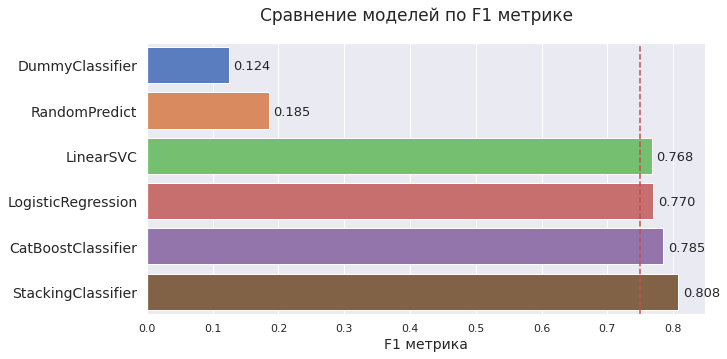

In [97]:
# сравнение метрик различных моделей по метрике F1 с помощью функции algo_comparison()
algo_comparison(
    result_df['f1_score'],
    result_df.index,
    'Сравнение моделей по F1 метрике',
    'F1 метрика',
    0.75
)

> * По результатам сравнительного анализа можно сделать вывод, что модели на основе опорных векторов *LinearSVC*, логистической регрессии *LogisticRegression*, градиентного бустинга *CatBoostClassifier* и мета-классификатора *StackingClassifiaer* более чем в четыре раза превзошли по метрике *F1* модели на основе простейших (*DummyClassifier*) и случайных (*RandomPredict*) предсказаний. Также все эти модели выполнили условие задания по метрике *F1* `≥0.75`.

### Выводы по обучению моделей

> * Модели на основе опорных векторов *LinearSVC*, логистической регрессии *LogisticRegression*, градиентного бустинга *CatBoostClassifier* и мета-классификатора *StackingClassifiaer* более чем в четыре раза превзошли по метрике *F1* модели на основе простейших (*DummyClassifier*) и случайных (*RandomPredict*) предсказаний. Также все эти модели выполнили условие задания по метрике *F1* `≥0.75`.
> * Лучшего значения по *F1* метрике, равного `0.785` позволил достичь градиентный бустинг *CatBoostClassifier*, на втором месте логистическая регрессия с результатом `0.770`.
> * Из двух лучших моделей - градиентного бустинга *CatBoostClassifier* и логистической регрессии *LogisticRegression* создан мета-классификатор *StackingClassifier*, который позволил достичь наивысшего значения метрики *F1*, равного `0.808`, превзойдя тем самым результаты отдельных моделей, из которых он образован. Эта же модель является и наиболее требовательной к вычислительным ресурсам.
> * Стекинг моделей с созданием мета-классификатора *StackingClassifier* позволил не только увеличить значение метрики *F1*, но также обеспечил достижение выдвинутого в задании условия *F1* `≥0.75` практически на всём диапазоне значений порога *threshold*.
> * Чтобы сделать предположения о возможных направлениях улучшения модели необходимо более подробно изучить результаты работы лучшей модели и проанализировать комментарии, на которых она ошибается.

## Анализ лучшей модели

Как было установлено ранее, по результатам обучения, лучшей моделью по метрике *F1* является мета-классификатор *StackingClassifiaer*. Но, так как результаты его работы являются производной от входящих в его состав двух других моделей (логистической регрессии *LogisticRegression* и градиентного бустинга *CatBoostClassifier*), то более целосообразно выполнить анализ результатов работы по одной из входящих в его состав моделей.

Поэтому, проведём анализ на результатах работы для второй в рейтинге по результатам *F1* метрики - градиентного бустинга *CatBoostClassifier*.

### Анализ порогового значения

Проанализируем то, насколько выбор оптимального порогового значения `threshold` способен повлиять на качество работы модели. Для этого получим значения вероятностей для тестового набора данных и объединим их с метками классов для последующего анализа.

In [98]:
# получение вероятностей отнесения к одному из классов для модели на основе CatBoostClassifier
cb_probs = model_cb.predict_proba(df_test[feature_names])[:,1]

In [99]:
# объединение вероятностей со значениями целевого признака
df_probs = (
    pd.concat([df_test[target], pd.Series(cb_probs, index=df_test[target].index)], axis=1)
    .rename(columns={0: 'probs'})
)

In [100]:
# просмотр первых строк полученной таблицы
df_probs.head()

,toxic,probs
86236,0,0.004965
65312,0,0.006059
83414,0,0.006024
94154,0,0.002383
51750,0,0.014025


Используя полученные данные, построим график зависимости распределения комментариев по вероятности их токсичности. В данном  случае на примере отнесения комментариев к классу `1`, то есть к токсичным комментариям. Чтобы лучше детализировать визуализацию проблемной зоны значения по оси `Y` ограничим диапазоном `0-1`.

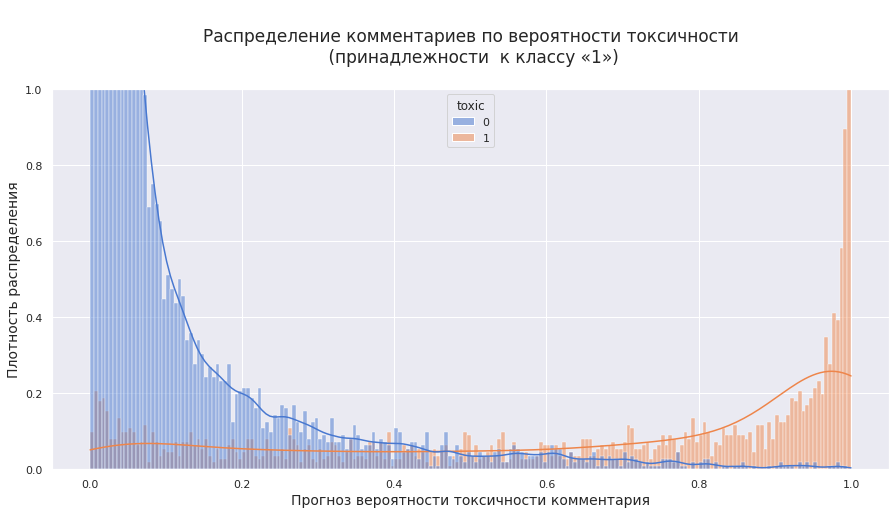

In [101]:
# посстроение графика распределение комментариев по вероятности их токсичности
sns.set()
sns.set_palette(palette='muted')
fig = plt.figure(figsize=(15, 7))
ax = sns.histplot(data=df_probs, x='probs', hue='toxic', stat='density', kde=True, bins=200)
ax.set_ylim(0, 1)
ax.set_title('\nРаспределение комментариев по вероятности токсичности\n (принадлежности  к классу «1»)\n', fontsize=17)
ax.set_xlabel('Прогноз вероятности токсичности комментария', fontsize=14)
ax.set_ylabel('Плотность распределения', fontsize=14)
plt.show();

> * Пересечение вероятностей отнесения к тому или иному классу происходит на всём диапазоне значений вероятности от `0` до `1`. При этом хвост прогнозов вероятностей у класса `1` более плотный. Это подтверждает выводы, сделанные по графику зависиммости метрик *precision*, *recall*, *F1* от порога *threshold*.
> * Исходя из предыдущего пункта представляется целесообразным смещение порога *threshold* левее. Конкретное значение для смещения необходимо согласовывать с бизнесом на основании баланса метрик *precision* и *recall*.

### Анализ матрицы ошибок

Для сопоставления предсказаний и реальных значений целевой переменной выведем матрицу ошибок (*confusion matrix*) – таблицу, в которой для результатов работы модели на основе *CatBoostClassifier* будут подсчитаны все возможные комбинациями прогнозируемых и фактических значений.

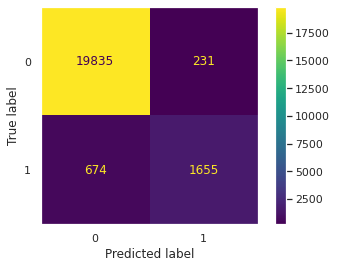

In [102]:
# получение матрицы ошибок для модели на основе CatBoostClassifier
plot_confusion_matrix(model_cb, df_test[feature_names], df_test[target], values_format = '')
plt.grid(visible=None)
plt.show();

Определим общее количество объектов в тестовой выборке, а также количество объектов каждого из классов.

In [103]:
# определение общего количества объектов в теcтовой выборке
total_count = df_test[target].shape[0]

print_tab_row('Общее количество объектов в тестовой выборке:', total_count, col_2_format='{: >10d} |')

-----------------------------------------------------------------------------------------------
| Общее количество объектов в тестовой выборке:                                   |     22395 |
-----------------------------------------------------------------------------------------------


In [104]:
# количество объектов класса 1 
class_1_count = (df_test[target] == 1).sum()

print_tab_row('Количество объектов класса «1»:', class_1_count, col_2_format='{: >10d} |')

-----------------------------------------------------------------------------------------------
| Количество объектов класса «1»:                                                 |      2329 |
-----------------------------------------------------------------------------------------------


In [105]:
# количество объектов класса 1 
class_0_count = total_count - class_1_count

print_tab_row('Количество объектов класса «0»:', class_0_count, col_2_format='{: >10d} |')

-----------------------------------------------------------------------------------------------
| Количество объектов класса «0»:                                                 |     20066 |
-----------------------------------------------------------------------------------------------


> * В качестве объекта для анализа выбрана модель градиентного бустинга *CatBoostClassifier*, так как стекинговый мета-классификатор *StackingClassifiaer* является производным от двух моделей, то есть более высокоуровневым компонентом, а анализ целесообразно начинать с более низких уровней.
> * Тестовая выборка включает в себя `22395` объектов. Из них `20066` объектов класса `0`, то есть НЕ токсичных комментариев и `2329` объектов класса `1`, то есть токсичных комментариев. Таким образом, в тестовом наборе данных сохранился характерный для исходных данных дисбаланс классов, заключающийся в том, что токсичных комментариев в общем объёме данных около `10%`.
> * Проанализируем матрицу ошибок по полученным значениям:
>     * `19835` значений *True Negative* (`TN`), когда комментарий не токсичный и модель предсказала его как нетоксичный;
>     * `1655` значений *True Positive* (`TP`), комментарий является токсичным и модель смогла распознать его как токсичный;
>     * `231` ошибка первого рода *False Positive* (`FP`), когда модель нетоксичный комментарий пометила как токсичный;
>     * `674` ошибки второго рода *False Negative* (`FN`), когда комментарий являлся токсичным, а модель распознала его как НЕ токсичный.
> * Таким образом, модель почти в три раза чаще совершает ошибки второго рода, пропуская токсичные комментарии. На `3.5` корректно распознанных токсичных комментария приходится `1` пропущенный.
> * Изучим каждую из групп ошибок более внимательно, чтобы определить возможные направления улучшения модели.

### Анализ ошибок первого рода

Создадним вспомогательный датафрейм, в который скопируем тестовый набор данных `df_test` и добавим к нему столбец предсказаний модели *CatBoostClassifier*.

In [106]:
# создание датафрейма со столбцом предсказаний
df_test_preds = df.loc[df_test.index, :]
df_test_preds['predict'] = model_cb.predict(df_test[feature_names])

In [107]:
# снятие ограничение на ширину текста, чтобы в таблице можно было увидеть весь комментарий
pd.set_option('display.max_colwidth', None)

Получим примеры ошибок первого рода (ложноположительных результатов) на коротких сообщениях с длиной `< 250`.

In [108]:
# получение ложноположительных результатов
df_test_preds.query(
    'toxic==0 & predict==1 & orig_len < 250'
)[['toxic', 'is_upper', 'orig_len', 'zip_ratio', 'text', 'clear_text']].head(25)

,toxic,is_upper,orig_len,zip_ratio,text,clear_text
137305,0,0,166,0.433735,Dick Merrill \n\nI think it was great of you to do a Wikipedia page for Dick Merrill. He was one of the Old Heads retired around Miami back in the 1960s and a fine guy.,dick merrill think great wikipedia page dick merrill one old heads retired around miami back fine guy
15941,0,0,42,0.642857,.. wow damn..Alison..Is that english?..lol,wow damn alison english lol
23345,0,0,31,0.354839,Mmmmm... goats! \n\n216.164.33.62,mmmmm goats
34178,0,0,126,0.468254,likely that he is the same guy who hates india..Cityvalyu (talk) \nblind or just racist or ingnorant choose one 81.151.101.146,likely guy hates india cityvalyu talk blind racist ingnorant choose one
16964,0,1,25,0.600000,GO TO THE NEXT PITSTOP!!!,go next pitstop
88650,0,1,69,0.608696,I DONT WANT TO BE UNBLOCKED - EVER TYVM. TYVM FOR BLOCKING ME. LOL.,dont want unblocked ever tyvm tyvm blocking lol
61353,0,0,35,0.600000,I KNOW YOU FROM SOULSEEK!!\n\nlololol,know soulseek lololol
18715,0,1,40,0.775000,I AM MOZARTS REINCARNATION WOOOOOOOOOOOO,mozarts reincarnation woooooooooooo
95772,0,0,99,0.535354,Ah go right to hell if it aint on MTV you dont care just goes to show how narrow-minded America is.,ah go right hell aint mtv dont care goes show narrow minded america
5352,0,0,108,0.611111,Anyone think it's funny democrats get caught with low class white girls and republicans get caught with men?,anyone think funny democrats get caught low class white girls republicans get caught men


На основе рассмотренных примеров ложноположительных прогнозовов модели возникает вопрос о качестве разметки исходных данных. Многие из просмотренных комментариев по своей сути скорее являются токсичными, что и определяется моделью. Некоторые примеры:
* Mmmmm... goats! \n\n216.164.33.62
* Anyone think it's funny democrats get caught with low class white girls and republicans get caught with men?
* My favourite kiddie is Josh H as he and I are very fond of cucumber destruction. (anus)
* EVERYBODY!!! EVERYBODY!!!! AMBERGRIS IS THE UNDIGESTED PART OF A GIANT SQUID STUCK IN A SPERM WHALES INTESTINES AND TESTICLES.
* LET ME ASK U 1 QUESTSHUN (SP), Y R U RACIST? WERE WILL IT GET U? HAS ANYTHIN UVE EVR DONE MADE UR LIFE BETTA?

Указанные примеры говорят об имеющихся недостатках в разметке исходных данных, которые целесообразно в последующем устранить, что также должно сказаться на повышении точности модели.

### Анализ ошибок второго рода

Получим примеры ошибок второго рода (ложноотрицательных результатов) на коротких сообщениях с длиной `< 250`.

In [109]:
# получение ложноотрицательных результатов
df_test_preds.query(
    'toxic==1 & predict==0 & orig_len < 250'
)[['toxic', 'is_upper', 'orig_len', 'zip_ratio', 'text', 'clear_text']].head(15)

,toxic,is_upper,orig_len,zip_ratio,text,clear_text
157156,1,0,85,0.376471,How big are Amanda Tapping's boobs\nHow big are Amanda Tapping's boobs?.98.236.110.176,big amanda tapping boobs big amanda tapping boobs
35685,1,0,62,0.500000,Arrogance\n\nHow pretentious of you to make a page for yourself.,arrogance pretentious make page
4425,1,0,244,0.413934,"Decline unblock \n\nYou declined my unblock request. Barrymcpeedmipants or wev his name is, is probably another student at my school, NOT me. If you understood this before it would make you real smarter than you currently are, you obnoxious cunt.",decline unblock declined unblock request barrymcpeedmipants wev name probably another student school understood would make real smarter currently obnoxious cunt
104950,1,0,104,0.471154,"""\n\n Whoa! \n\nHaha, aren't you glad I didn't put a section called """"Penis size"""" on your talk page? ;) """,whoa haha glad put section called penis size talk page
24675,1,0,28,0.821429,Wikipedia is a Comunist Plot,wikipedia comunist plot
155020,1,0,117,0.538462,opinion/origin \n\nIt is my opinion that lip stick originated from the placing or vaginal excrement onto lips of women.,opinion origin opinion lip stick originated placing vaginal excrement onto lips women
106570,1,0,77,0.610390,This article sucks \n\nI would nominate it for deletion if it wasn't protected.,article sucks would nominate deletion protected
66964,1,0,119,0.462185,hey \n\nhey persian gal. i have got a couple of your pubes from when we had some naughty fun back at school.\n\nup 4 cyber?,hey hey persian gal got couple pubes naughty fun back school cyber
100094,1,0,98,0.377551,"How do you get semen stains off jeans?\nHow do you get semen stains off jeans? - Tim, 20 July, 2009",get semen stains jeans get semen stains jeans tim july
35388,1,0,169,0.420118,Who is Osama bin Laden? Sunni. Who is Mullah Omer? Sunni. Who are Al-Qaida? Sunnis. Who has the belief that apostasy is punishable by death? Sunnis. Who are you kidding?,osama bin laden sunni mullah omer sunni al qaida sunnis belief apostasy punishable death sunnis kidding


По указанным примерам можно сделать следующие предположения о возможных направлениях улучшения модели:
* следует рассмотреть возможность добавления нового признака в виде количества обсценной лексики в комментарии (boobs, vagina, nazi, penis, racist, dick, gay, porn, asshole, masturbation, fool и т.д.);
- можно попробовать усовершенствовать признак UPPERCASE, например, считая долю символов в UPPERCASE относительно всего текста;
- следует собрать базу и отдельно интерпретировать нецензурные слова с пропусками и заменами букв, или типичными сокращениями (например, f*ing, WTF и т.д.).

### Выводы по анализу лучшей модели

> * Проведённый анализ результатов работы лучшей модели позволил установить, что она в `3` раза чаще совершает ошибки второго рода, чем первого, чаще пропуская токсичные комментарии, чем помечая токсичной меткой нетоксичный комментарий. Таким образом, на дефолтном пороге `threshold`, равном `0.5`, метрика `recall` хуже метрики `precision`. Это плохо с точки зрения бизнеса, так как пропуски токсичных комментариев потенциально могут нанести больше вреда интернет-магазину «Викишоп» в виде репутационных издержек, чем она потратит денежных средств на дополнительную оплату труда модератора, если модель станет больше совершать ошибок первого рода, отпрявляя большее количество комментариев на модерацию.
> * Исходя из предыдущего пункта, для рабочей модели метрику `recall` целесообразно повышать за счёт ухудшения `precision`. Самый простой путь для этого - сместить левее пороговое значение `threshold` для отнесения к тому или классу, например к значению `0.35`, на котором линии графиков `recall` и `precision` пересекаются. Целесообразность этого подтверждена графиком распределения комментариев по вероятности их токсичности (принадлежности к классу `1`). Значение для смещения необходимо согласовывать с требованиями бизнеса.
> * Также возможно провести дополнительное исследование на предмет улучшения качества работы моделей за счёт введения дополнительных признаков. Например, добавить атрибут в виде количества обсценной лексики в комментарии. Или улучшить уже существующие признаки. Например, признак UPPERCASE определять не для всего текста комментария, а считать долю символов в верхнем регистре относительно общей длины текста комментария.
> * Использовать для решения задачи специализированные решения для работы с текстами в виде моделей на основе *BERT*.

## Классификация на эмбеддингах BERT

Используем нейронную сеть на эмбеддингах *BERT* для классификации комментариев. Для ускорение расчётов из исходного датасета возьмём небольшую подвыборку из первых `5000` объектов, получим для них эмбединги, далее разобъём их на обучающую и тестовую подвыборки и обучим модель на основе логистической регрессии.

Код с обучением *BERT* закомментирован. Вместо обучения с помощью *pickle* подгружаются предварительно сохранённые эмбеддинги.

In [110]:
# удаление переменных для освобождения оперативной памяти
del classifier, meta_classifier, model_svc, model_lr, model_cb, train, valid, f1_rnd_values, corpus, 
del tf_idf_train, tf_idf_test

In [111]:
import torch
import transformers
from tqdm import notebook

In [112]:
%%time
tokenizer = transformers.BertTokenizer(
    vocab_file='./datasets/ds_bert/vocab.txt')

texts = df.loc[df['orig_len'] < 1000]['text'].iloc[:5000]

tokenized = texts.apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True))

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

In [113]:
attention_mask.shape

Инициализируем модель *BERT*, передадим ей файлы с предобученной моделью и конфигурационными настройками.

In [114]:
# инициализация BERT, подгрузка предобученной модели и конфигурационных настроек

config = transformers.BertConfig.from_json_file(
    './datasets/ds_bert/config.json')
model = transformers.BertModel.from_pretrained(
    './datasets/ds_bert/pytorch_model.bin', config=config)

Преобразуем тексты в эмбеддинги небольшими батчами для уменьшения расходования оперативной памяти.

In [115]:
# преобразование текстов в эмбеддинги
batch_size = 100
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

Соберём все эмбеддинги в матрицу признаков и разделим её на обучающую и тестовую части.

In [116]:
# соберём все эмбеддинги в матрицу признаков с помощью функции concatenate() и сохраним её с помощью pickle 
# для экономии времени при последующих перезапусках кода
try:
    with open('features.pkl', 'rb') as f:
        features = pickle.load(f)
except FileNotFoundError:
    features = np.concatenate(embeddings)
    
    with open('features.pkl', 'wb') as f:
        pickle.dump(features, f)

indexes = texts.index

# разделим выборку на обучающую и тестовую части
X_train, X_test, y_train, y_test = train_test_split(
    features, df['toxic'].loc[indexes], test_size=0.25, random_state=RND)

Создадим и обучим модель логистической регрессии на полученных эмбеддингах.

In [117]:
# создание модели логистической регрессии
model_lr_bert = LogisticRegression(max_iter=5000, random_state=RND)

In [118]:
# обучение модели логистической регрессии на эмбеддингах
model_lr_bert.fit(X_train, y_train)

LogisticRegression(max_iter=5000, random_state=123)

Получим предсказания для тестовой выборки от полученной модели и найдём для них значение *F1*-метрики.

In [119]:
y_pred = model_lr_bert.predict(X_test)

In [120]:
# получение метрики F1 модели на основе BERT на тестовой выборке
f1_value = f1_score(y_pred, y_test)

print_tab_row(
    'F1 на тестовых данных для модели на основе BERT:', f1_value, col_2_format='{: >10.3f} |')

-----------------------------------------------------------------------------------------------
| F1 на тестовых данных для модели на основе BERT:                                |     0.938 |
-----------------------------------------------------------------------------------------------


> * Несмотря на то, что сравнивать результаты модели на основе *BERT* эмбеддингов с результатами предыдущих моделей некорректо, так как тестовые выборки у них различны, высокий результат по *F1*-метрике для модели на основе *BERT*, равный `0.938`, позволяет предположить, что данное спецализированное для работы с текстовыми данными решение является наиболее перспективным для решаемой задачи при наличии достаточных вычислительных ресурсов.

## Общие выводы

> 1. Полученные в файлe `toxic_comments.csv` исходные данные с комментариями загружены и проанализированы:
>    * в полученных данных содержится около  `160` тыс. записей из двух признаков;
>        * текст (комментарий)
>        * признак токсичности комментария (целевой признак)
>    * полных дубликатов в исходном наборе данных не обнаружено;
>    * доля токсичных комментариев в общем объёме данных около `10%`, что свидетельствует о наличии дисбаланса в целевом признаке, который следует учитывать при обучении моделей;
>    * по условию задачи требовалось получить модель, позволяющую классифицировать текст по признаку токсичности с целевым значением метрики качества *F1* равным `0.75`;
>    * на этапе предобработки данных проведена очистка текста, обучающие признаки дополнены несколькими синтетическими признаками, в частности `zip_ratio` - соотношением объёма сжатого очищенного текста к исходному объёму текста;
>    * на этапе анализа данных проведена оценка распределения значений обучающих признаков по целевым классам, устранены отдельные выбросы;
>    * сформированы обучающая и тестовая выборки для последующего обучения моделей.
>
>
> 2. Выполнено обучение различных моделей, определяющих признак токсичности комментария, и проведён их сравнительный анализ:
>    * для моделей, которые не могут работать с текстовыми данными, корпуса слов обучающей и тестовой выборок были преобразованы в векторное представление TF-IDF с преобразованием в разреженные матрицы (*sparse matrix*);
>    * в качестве базовых моделей обучены *DummyClassifier* на основе стратегии `stratified`, возвращающей вероятности отнесения к одному из классов по аналогии с распределением аналогичных классов в тренировочной выборке, и модель на рандомных случайных предсказаниях целевой переменной, обе эти модели обеспечили результат по *F1* метрике `0.124` и `0.184` соотвественно;
>    * проведено обучение 3 видов моделей машинного обучения:
>        * *LinearSVC* (классификатора на основе опорных векторов);
>        * логистической регрессии *LogisticRegression*;
>        * градиентного бустинга *CatBoostClassifier*.
>    * модели на основе опорных векторов *LinearSVC*, логистической регрессии *LogisticRegression* и градиентного бустинга *CatBoostClassifier* более чем в четыре раза превзошли по метрике *F1* модели на основе простейших (*DummyClassifier*) и случайных (*RandomPredict*) предсказаний и выполнили условие задания по метрике *F1* `≥0.75`;
>    * лучшего значения *F1* метрики, равного `0.785`, из этих трёх моделей позволил достичь градиентный бустинг *CatBoostClassifier*, на втором месте логистическая регрессия с результатом `0.770`;
>    * стекинг двух лучших моделей в одном мета-классификаторе *StackingClassifier* позволил улучшить значение метрики *F1*, до значения `0.808`, а также обеспечил достижение выдвинутого в задании условия *F1* `≥0.75` практически на всём диапазоне значений порога *threshold*.
>
>
> 3. Проведён анализ лучшей модели и результатов её работы:
>    * в качестве объекта для анализа выбрана модель градиентного бустинга *CatBoostClassifier*, так как стекинговый мета-классификатор *StackingClassifiaer* является производным от двух моделей, то есть более высокоуровневым компонентом, а анализ целесообразно начинать с более низких уровней;
>    * на основании анализа матрицы ошибок установлено, что она в `3` раза чаще совершает ошибки второго рода, чем первого, чаще пропуская токсичные комментарии, чем помечая токсичной меткой нетоксичный комментарий, а это в свою очередь свидетельствет о более низком значении метрики `recall` по отношению к `precision` для выбранного значения порога классификации `threshold`, равного `0.5`;
>    * сделано заключение, что с точки зрения бизнеса более важна всё же метрика `recall`, чем `precision` и поэтому, возможно будет являться целесообразным смещение порога классификации `threshold` левее, например до значения `0.35`, на котором линии графиков `recall` и `precision` пересекаются;
>    * установлено, что имеются проблемы с разметкой данных из-за чего размеченные как нетоксичные комментарии распознаются моделью как токсичные и по факту таковыми они и являются;
>    * выдвинуты предположения о дальнейшем повышении качества работы модели, которое может заключаться как во введении дополнительных признаков, например, атрибута в виде количества обсценной лексики в комментарии, или в улучшении уже существующих признаков, например, например более дифференцированного определения признака UPPERCASE в виде его расчёта в долях символов в верхнем регистре относительно общей длины текста комментария.
>
>
> 4. Опробовано специализированное решение для работы с текстовыми данными на основе *BERT*:
>    * для ускорения расчётов объём выборки сокращён до `5000` объектов;
>    * инициализирована модель *BERT* на основе текстовых данных получены соотвествующие им эмбеддинги;
>    * сокращённая выборка разделена на обучающую и тестовую подвыборки, на которых обучена и протестирована модель логистической регрессии;
>    * получено значение *F1*-метрики на тестовых данных для модели на основе BERT, равное `0.938`;
>    * высокий результат по *F1*-метрике для модели на основе *BERT* позволяет предположить, что данное решение является наиболее перспективным для решаемой задачи при наличии достаточных вычислительных ресурсов.